# 05_LargeScale_Maps
Relation to large-scale patterns of atm. forcing

In [1]:
%load_ext autoreload
%autoreload 2


import warnings

# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import calendar
from calendar import monthrange

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import cmocean
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import Normalize
import matplotlib.ticker as ticker
# from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FixedLocator

import matplotlib.dates as mdates


from scipy import stats



from matplotlib.patches import PathPatch
from matplotlib.path import Path
from matplotlib.patches import Circle


# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy import img_transform

from metpy.units import units

# path to own functions
sys.path.append('../../')
import timeseries.adjust as tseries
import timeseries.analyze as tanalyze
import geofunc.general as geogen
import geofunc.vectors as vectors
import geofunc.shapes as geoshape
import plot_simply.general as plotter
import plot_simply.geomap as geomap
import data_nsidc.icedrift as icedrift
import data_unibremen.SIC as unisic


sys.path.append('../')
import functions as fn

plt.style.use('../jgr_oceans.mplstyle')

def SAVE(fig, filename):
    fig.savefig(filename, bbox_inches='tight', pad_inches=0.05)


In [2]:
from pyproj import Geod
g = Geod(ellps='WGS84')

### Import constants

In [3]:
# Save to file
df = pd.read_csv('../data/constants.csv')
df = df.set_index('var')
df

cst = {}
for variable in list(df.index):
    cst[variable] = df.loc[variable]['value'] * units(df.loc[variable]['units'])
    
cst

{'Cp_o': <Quantity(3850.0, 'joule / kilogram / delta_degree_Celsius')>,
 'Cp_a': <Quantity(1004.0, 'joule / kilogram / delta_degree_Celsius')>,
 'sigma_sb': <Quantity(5.670367e-08, 'watt / meter ** 2 / kelvin ** 4')>,
 'rho_a': <Quantity(1.225, 'kilogram / meter ** 3')>,
 'rho_o': <Quantity(1028.0, 'kilogram / meter ** 3')>,
 'rho_i': <Quantity(917.0, 'kilogram / meter ** 3')>,
 'L_i': <Quantity(334000.0, 'joule / kilogram')>,
 'k_i': <Quantity(2.2, 'watt / meter / delta_degree_Celsius')>,
 'kappa': <Quantity(0.4, 'dimensionless')>,
 'St': <Quantity(0.0057, 'dimensionless')>,
 'omega': <Quantity(7.2921e-05, 'radian / second')>}

## Reference grids

In [4]:

# open regional bounding coordinates
df = pd.read_csv('../data/coastal_region_bounds_v7.csv')
reg_poly = geoshape.make_polygon(np.stack((df['lons'], df['lats']), axis=1))



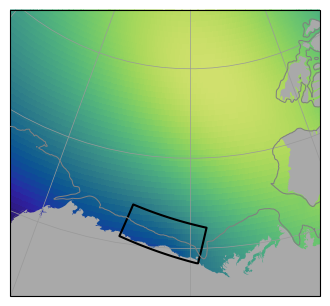

In [24]:
fig, ax = fn.makemap(view='large_view', contours = [], 
                      panels=(1,1), figsize=(4,4))
ax.add_geometries ([reg_poly], lw=1.5, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())
FS = 12


line_kwargs = {'lw':0.5, 'c':[0.6,0.6,0.6]}
for lat in np.arange(66,90,4):
    ax.plot(np.linspace(0,359,100), np.full(100,lat), transform=ccrs.PlateCarree(), **line_kwargs)  
for lon in np.arange(0,360,20):
    ax.plot(np.full(100,lon), np.linspace(65,90,100), transform=ccrs.PlateCarree(), **line_kwargs)
ax.contour(dsb.xx, dsb.yy, dsb.avg, levels=[-100], 
           colors=['gray'],linewidths=[0.75],linestyles='solid', transform=dsic['proj'], zorder=100)    
    
    
sp = 1
mesh = ax.pcolormesh(era_map[key]['lon'][::sp,::sp], era_map[key]['lat'][::sp,::sp],
                   np.nanmean(era_map[key]['msl'], axis=0)[::sp,::sp]/100, 
                   vmin=1010,vmax=1030, 
                   cmap=cmocean.cm.haline, transform=ccrs.PlateCarree(), zorder=-1)

# mesh = ax.contourf(era_map[key]['lon'], era_map[key]['lat'],
#                    np.nanmean(era_map[key]['msl'], axis=0)/100, 
#                    vmin=1010,vmax=1030, extend='both', levels=np.arange(1010,1030,1),
#                    cmap=cmocean.cm.haline, transform=ccrs.PlateCarree(), zorder=-1)

<>:82: SyntaxWarning: invalid escape sequence '\m'
<>:82: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_48279/392412944.py:82: SyntaxWarning: invalid escape sequence '\m'
  qk = ax.quiverkey(Q, X=0.15, Y=0.05, U=5, label='$\mathrm{5\;m\;s^{-1}}$ wind', labelpos='E', coordinates='axes')


(<matplotlib.colorbar.Colorbar at 0x14ea2fa70>,
 <Axes: xlabel='\nSea level pressure (hPa)'>)

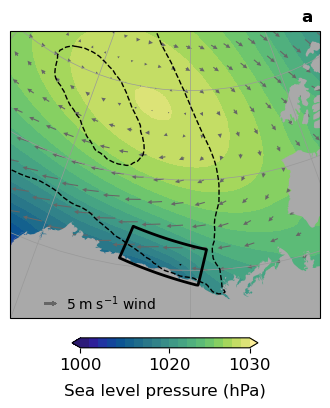

In [177]:
fig, ax = fn.makemap(view='large_view', contours = [], 
                      panels=(1,1), figsize=(4,4))


# fig, ax = fn.makemap(view='wider_zoom2', contours = [], 
#                       panels=(1,1), figsize=(4,4))


FS = 12

ax.add_geometries ([reg_poly], lw=2, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())


line_kwargs = {'lw':0.5, 'c':[0.6,0.6,0.6]}
for lat in np.arange(66,90,4):
    ax.plot(np.linspace(0,359,100), np.full(100,lat), transform=ccrs.PlateCarree(), **line_kwargs)  
for lon in np.arange(0,360,20):
    ax.plot(np.full(100,lon), np.linspace(65,90,100), transform=ccrs.PlateCarree(), **line_kwargs)
    
key = 'close_wind'
u1 = np.nanmean(era_map[key]['u10'], axis=0)
v1 = np.nanmean(era_map[key]['v10'], axis=0)
s1 = np.nanmean(np.sqrt(era_map[key]['u10']**2+era_map[key]['v10']**2), axis=0)

key2 = 'open_wind'
u2 = np.nanmean(era_map[key2]['u10'], axis=0)
v2 = np.nanmean(era_map[key2]['v10'], axis=0)
s2 = np.nanmean(np.sqrt(era_map[key2]['u10']**2+era_map[key2]['v10']**2), axis=0)

vec_diff = np.sqrt((u1-u2)**2+(v1-v2)**2)

dc1 = np.sqrt(u1**2+v1**2)/s1

all_u = np.concatenate((era_map[key]['u10'], era_map[key2]['u10']), axis=0)
all_v = np.concatenate((era_map[key]['v10'], era_map[key2]['v10']), axis=0)
all_s = np.nanmean(np.sqrt(all_u**2 + all_v**2), axis=0)
dc_all = np.sqrt(np.nanmean(all_u, axis=0)**2+np.nanmean(all_v, axis=0)**2) / all_s



norm_vec_diff = vec_diff  / all_s
    
ax.text(0.975,1.025,'a',color='k', size=FS, weight='bold', ha='right', va='bottom', clip_on=False,transform=ax.transAxes)


# sp = 5
# mesh = ax.pcolormesh(era_map[key]['lon'][::sp,::sp], era_map[key]['lat'][::sp,::sp],
#            np.nanmean(era_map[key]['msl'][:,::sp,::sp], axis=0)/100, 
#               vmin=1010,vmax=1030, extend='both', levels=np.arange(1010,1030,1),
#               cmap=cmocean.cm.haline, transform=ccrs.PlateCarree(), zorder=-1)




mesh = ax.contourf(era_map[key]['lon'], era_map[key]['lat'],
           np.nanmean(era_map[key]['msl'], axis=0)/100, 
              vmin=1010,vmax=1030, extend='both', levels=np.arange(1010,1030,1),
              cmap=cmocean.cm.haline, transform=ccrs.PlateCarree(), zorder=-1)


# ax.contourf(era_map[key]['lon'], era_map[key]['lat'], vec_diff, 
#                  levels=[6,20], colors=['k'], alpha=0.1, linestyles='dashed', linewidths=1, transform=ccrs.PlateCarree())
ax.contour(era_map[key]['lon'], era_map[key]['lat'], vec_diff, 
                 levels=[2,3,], colors=['k'], linestyles='dashed', linewidths=1, transform=ccrs.PlateCarree())

# ax.contour(era_map[key]['lon'], era_map[key]['lat'], dc1-dc_all, 
#                  levels=[0.65], colors=['k'], linestyles='dashed', linewidths=1, transform=ccrs.PlateCarree())


# sp1, sp2 = 1,3
# ax.scatter(era_map[key]['lon'][::sp1,::sp2][vec_diff[::sp1,::sp2]>7], 
#            era_map[key]['lat'][::sp1,::sp2][vec_diff[::sp1,::sp2]>7],
#            c='k', s=1, transform=ccrs.PlateCarree())

# wind vectors
U,V =geomap.fix_cartopy_vectors(u1,v1, era_map[key]['lat'])
sp1, sp2 = 4,13
Q = ax.quiver(era_map[key]['lon'][::sp1,::sp2], era_map[key]['lat'][::sp1,::sp2], U[::sp1,::sp2], V[::sp1,::sp2], 
          angles='xy', scale_units='xy', transform=ccrs.PlateCarree(),
          scale=0.00008, width=0.0035, headwidth=4,headlength=4, headaxislength=4, 
              color=[0.4,0.4,0.4], pivot='tail', zorder=1)
qk = ax.quiverkey(Q, X=0.15, Y=0.05, U=5, label='$\mathrm{5\;m\;s^{-1}}$ wind', labelpos='E', coordinates='axes')
qk.set_zorder(100)

# ax.contour(dsb.xx, dsb.yy, dsb.avg, levels=[-100], 
#            colors=['gray'],linewidths=[0.75],linestyles='solid', transform=dsic['proj'])

plotter.add_colorbar(fig, ax, [mesh], cb_placement='bottom', cb_orientation='auto', 
                     cb_width=0.025, cb_length_fraction=[0.2, 0.8], cb_pad=0.05, cb_ticks=[1000, 1020,1030], 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='\nSea level pressure (hPa)', labelpad=-5, 
                     cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
                     cb_labelsize=FS, draw_edges=False, edge_params=['k', 2])

# fig.savefig('../figures/results/composite_wide_atm.png', dpi=400, bbox_inches='tight', pad_inches=0)


<>:58: SyntaxWarning: invalid escape sequence '\m'
<>:63: SyntaxWarning: invalid escape sequence '\m'
<>:58: SyntaxWarning: invalid escape sequence '\m'
<>:63: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_48279/2384386400.py:58: SyntaxWarning: invalid escape sequence '\m'
  qk = ax.quiverkey(Q, X=0.15, Y=0.05, U=7*20000, label='$\mathrm{20\;km\;d^{-1}}$ ice drift', labelpos='E', coordinates='axes')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_48279/2384386400.py:63: SyntaxWarning: invalid escape sequence '\m'
  cb_ticklabels='auto', cb_extend='neither', cb_label='\nSea ice speed ($\mathrm{km\;d^{-1}}$)', labelpad=-5,
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_48279/2384386400.py:26: RuntimeWarning: Mean of empty slice
  u1 = np.nanmean(drift_map[key]['u'], axis=0)*units('cm/s').to('km/day').magnitude
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_48279/2384386400.py:27: RuntimeWarning: M

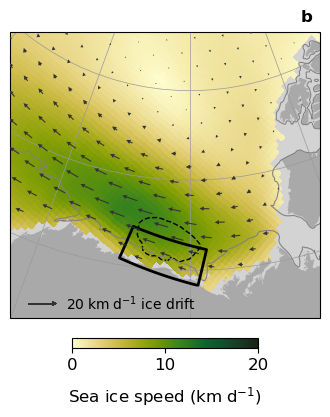

In [181]:
fig, ax = fn.makemap(view='large_view', contours = [], 
                      panels=(1,1), figsize=(4,4))


# fig, ax = fn.makemap(view='wider_zoom2', contours = [], 
#                       panels=(1,1), figsize=(4,4))


FS = 12

ax.add_geometries ([reg_poly], lw=2, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())


line_kwargs = {'lw':0.5, 'c':[0.6,0.6,0.6]}
for lat in np.arange(66,90,4):
    ax.plot(np.linspace(0,359,100), np.full(100,lat), transform=ccrs.PlateCarree(), **line_kwargs)  
for lon in np.arange(0,360,20):
    ax.plot(np.full(100,lon), np.linspace(65,90,100), transform=ccrs.PlateCarree(), **line_kwargs)
    
    
ax.text(0.975,1.025,'b',color='k', size=FS, weight='bold', ha='right', va='bottom', clip_on=False,transform=ax.transAxes)


key = 'close_wind'
sp = 1
u1 = np.nanmean(drift_map[key]['u'], axis=0)*units('cm/s').to('km/day').magnitude
v1 = np.nanmean(drift_map[key]['v'], axis=0)*units('cm/s').to('km/day').magnitude
s1 = np.nanmean(np.sqrt(drift_map[key]['u']**2+drift_map[key]['v']**2), axis=0)*units('cm/s').to('km/day').magnitude
sm = np.sqrt(u1**2+v1**2)
mesh = ax.pcolormesh(drift_map[key]['xx'][::sp,::sp], drift_map[key]['yy'][::sp,::sp], sm[::sp,::sp], 
             vmin=0, vmax=20, transform=drift_map[key]['proj'], cmap=cmocean.cm.speed)

# vector difference
key2 = 'open_wind'
u2 = np.nanmean(drift_map[key2]['u'], axis=0)*units('cm/s').to('km/day').magnitude
v2 = np.nanmean(drift_map[key2]['v'], axis=0)*units('cm/s').to('km/day').magnitude
vec_diff = np.sqrt((u1-u2)**2+(v1-v2)**2)
# ax.contourf(drift_map[key]['xx'][::sp,::sp], drift_map[key]['yy'][::sp,::sp], vec_diff[::sp,::sp], 
#                  levels=[10,100], colors=['k'], linestyles='dashed', alpha=0.05, linewidths=1, transform=drift_map[key]['proj'])
ax.contour(drift_map[key]['xx'][::sp,::sp], drift_map[key]['yy'][::sp,::sp], vec_diff[::sp,::sp], 
                 levels=[9,11,13], colors=['k'], linestyles='dashed', linewidths=1, transform=drift_map[key]['proj'])


# sp = 1
# ax.scatter(drift_map[key]['xx'][::sp,::sp][vec_diff[::sp,::sp]>11], 
#            drift_map[key]['yy'][::sp,::sp][vec_diff[::sp,::sp]>11],
#            c='k', s=1, transform=drift_map[key]['proj'])



sp = 4
u1 = 7*np.nanmean(drift_map[key]['u'], axis=0)*units('cm/s').to('m/day').magnitude
v1 = 7*np.nanmean(drift_map[key]['v'], axis=0)*units('cm/s').to('m/day').magnitude
Q = ax.quiver(drift_map[key]['xx'][::sp,::sp], drift_map[key]['yy'][::sp,::sp], u1[::sp,::sp], v1[::sp,::sp], 
          angles='xy', scale_units='xy', transform=drift_map[key]['proj'],
          scale=1, width=0.0035, headwidth=4,headlength=4, headaxislength=4, color=[0.2,0.2,0.2], pivot='tail', zorder=100)

qk = ax.quiverkey(Q, X=0.15, Y=0.05, U=7*20000, label='$\mathrm{20\;km\;d^{-1}}$ ice drift', labelpos='E', coordinates='axes')


plotter.add_colorbar(fig, ax, [mesh], cb_placement='bottom', cb_orientation='auto', 
                     cb_width=0.025, cb_length_fraction=[0.2, 0.8], cb_pad=0.05, cb_ticks=[0,10,20], 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='\nSea ice speed ($\mathrm{km\;d^{-1}}$)', labelpad=-5, 
                     cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
                     cb_labelsize=FS, draw_edges=False, edge_params=['k', 2])

# plotter.add_colorbar(fig, ax, [mesh], cb_placement='top', cb_orientation='auto', 
#                      cb_width=0.025, cb_length_fraction=[0.2, 0.8], cb_pad=0.05, cb_ticks=[1000, 1020,1030], 
#                      cb_ticklabels='auto', cb_extend='neither', cb_label='Sea level pressure (hPa)\n', labelpad=-5, 
#                      cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
#                      cb_labelsize=FS, draw_edges=False, edge_params=['k', 2])


ax.contour(dsb.xx, dsb.yy, dsb.avg, levels=[-100], 
           colors=['gray'],linewidths=[0.75],linestyles='solid', transform=dsic['proj'])


In [210]:
key = 'all'
u1 = np.nanmean(era_map[key]['u10'], axis=0)
v1 = np.nanmean(era_map[key]['v10'], axis=0)
s1 = np.nanmean(np.sqrt(era_map[key]['u10']**2+era_map[key]['v10']**2), axis=0)

key2 = 'comp'
u2 = np.nanmean(era_map[key2]['u10'], axis=0)
v2 = np.nanmean(era_map[key2]['v10'], axis=0)
s2 = np.nanmean(np.sqrt(era_map[key2]['u10']**2+era_map[key2]['v10']**2), axis=0)

vec_diff = np.sqrt((u1-u2)**2+(v1-v2)**2)

dc1 = np.sqrt(u1**2+v1**2)/s1

all_u = np.concatenate((era_map[key]['u10'], era_map[key2]['u10']), axis=0)
all_v = np.concatenate((era_map[key]['v10'], era_map[key2]['v10']), axis=0)
all_s = np.nanmean(np.sqrt(all_u**2 + all_v**2), axis=0)
dc_all = np.sqrt(np.nanmean(all_u, axis=0)**2+np.nanmean(all_v, axis=0)**2) / all_s



norm_vec_diff = vec_diff  / all_s


<>:70: SyntaxWarning: invalid escape sequence '\m'
<>:70: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_60892/1671227203.py:70: SyntaxWarning: invalid escape sequence '\m'
  qk = ax.quiverkey(Q, X=0.15, Y=0.05, U=5, label='$\mathrm{5\;m\;s^{-1}}$ wind', labelpos='E', coordinates='axes')


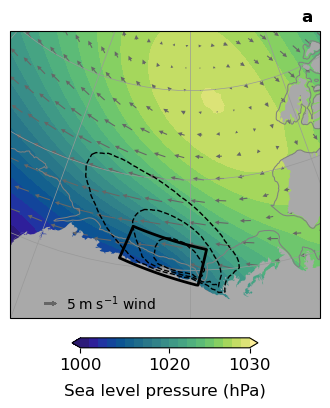

In [211]:
fig, ax = fn.makemap(view='large_view', contours = [], 
                      panels=(1,1), figsize=(4,4))


# fig, ax = fn.makemap(view='wider_zoom2', contours = [], 
#                       panels=(1,1), figsize=(4,4))


FS = 12

ax.add_geometries ([reg_poly], lw=2, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())


line_kwargs = {'lw':0.5, 'c':[0.6,0.6,0.6]}
for lat in np.arange(66,90,4):
    ax.plot(np.linspace(0,359,100), np.full(100,lat), transform=ccrs.PlateCarree(), **line_kwargs)  
for lon in np.arange(0,360,20):
    ax.plot(np.full(100,lon), np.linspace(65,90,100), transform=ccrs.PlateCarree(), **line_kwargs)
    
    
# key = 'all'
# u1 = np.nanmean(era_map[key]['u10'], axis=0)
# v1 = np.nanmean(era_map[key]['v10'], axis=0)

# key2 = 'comp'
# u2 = np.nanmean(era_map[key2]['u10'], axis=0)
# v2 = np.nanmean(era_map[key2]['v10'], axis=0)

# vec_diff = np.sqrt((u1-u2)**2+(v1-v2)**2)
    
ax.text(0.975,1.025,'a',color='k', size=FS, weight='bold', ha='right', va='bottom', clip_on=False,transform=ax.transAxes)


# sp = 5
# mesh = ax.pcolormesh(era_map[key]['lon'][::sp,::sp], era_map[key]['lat'][::sp,::sp],
#            np.nanmean(era_map[key]['msl'][:,::sp,::sp], axis=0)/100, 
#               vmin=1010,vmax=1030, extend='both', levels=np.arange(1010,1030,1),
#               cmap=cmocean.cm.haline, transform=ccrs.PlateCarree(), zorder=-1)




mesh = ax.contourf(era_map[key]['lon'], era_map[key]['lat'],
           np.nanmean(era_map[key]['msl'], axis=0)/100, 
              vmin=1010,vmax=1030, extend='both', levels=np.arange(1010,1030,1),
              cmap=cmocean.cm.haline, transform=ccrs.PlateCarree(), zorder=-1)


# ax.contourf(era_map[key]['lon'], era_map[key]['lat'], vec_diff, 
#                  levels=[6,20], colors=['k'], alpha=0.1, linestyles='dashed', linewidths=1, transform=ccrs.PlateCarree())
ax.contour(era_map[key]['lon'], era_map[key]['lat'], vec_diff, 
                 levels=[6,7,8], colors=['k'], linestyles='dashed', linewidths=1, transform=ccrs.PlateCarree())

# ax.contour(era_map[key]['lon'], era_map[key]['lat'], dc1-dc_all, 
#                  levels=[0.65], colors=['k'], linestyles='dashed', linewidths=1, transform=ccrs.PlateCarree())


# sp1, sp2 = 1,3
# ax.scatter(era_map[key]['lon'][::sp1,::sp2][vec_diff[::sp1,::sp2]>7], 
#            era_map[key]['lat'][::sp1,::sp2][vec_diff[::sp1,::sp2]>7],
#            c='k', s=1, transform=ccrs.PlateCarree())

# wind vectors
U,V =geomap.fix_cartopy_vectors(u1,v1, era_map[key]['lat'])
sp1, sp2 = 4,13
Q = ax.quiver(era_map[key]['lon'][::sp1,::sp2], era_map[key]['lat'][::sp1,::sp2], U[::sp1,::sp2], V[::sp1,::sp2], 
          angles='xy', scale_units='xy', transform=ccrs.PlateCarree(),
          scale=0.00008, width=0.0035, headwidth=4,headlength=4, headaxislength=4, 
              color=[0.4,0.4,0.4], pivot='tail', zorder=1)
qk = ax.quiverkey(Q, X=0.15, Y=0.05, U=5, label='$\mathrm{5\;m\;s^{-1}}$ wind', labelpos='E', coordinates='axes')
qk.set_zorder(100)

ax.contour(dsb.xx, dsb.yy, dsb.avg, levels=[-100], 
           colors=['gray'],linewidths=[0.75],linestyles='solid', transform=dsic['proj'])

plotter.add_colorbar(fig, ax, [mesh], cb_placement='bottom', cb_orientation='auto', 
                     cb_width=0.025, cb_length_fraction=[0.2, 0.8], cb_pad=0.05, cb_ticks=[1000, 1020,1030], 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='\nSea level pressure (hPa)', labelpad=-5, 
                     cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
                     cb_labelsize=FS, draw_edges=False, edge_params=['k', 2])

fig.savefig('../figures/results/composite_wide_atm.png', dpi=400, bbox_inches='tight', pad_inches=0)


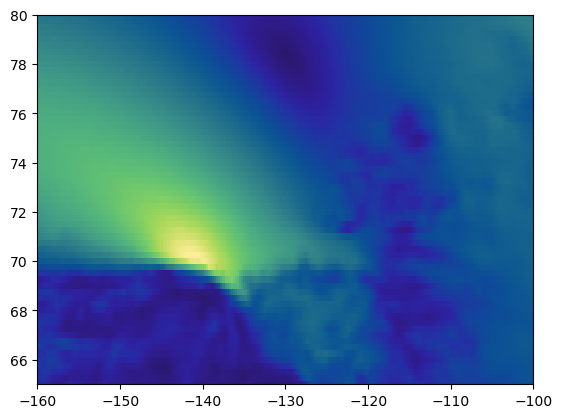

In [138]:
fig, ax = plt.subplots()
ax.set_xlim(-160,-100)
ax.set_ylim(65,80)

key = 'all'
u1 = np.nanmean(era_map[key]['u10'], axis=0)
v1 = np.nanmean(era_map[key]['v10'], axis=0)

key2 = 'comp'
u2 = np.nanmean(era_map[key2]['u10'], axis=0)
v2 = np.nanmean(era_map[key2]['v10'], axis=0)

vec_diff = np.sqrt((u1-u2)**2+(v1-v2)**2)

norm_bg = np.sqrt((u1-u2)**2+(v1-v2)**2)

# ax.contour(era_map[key]['lon'], era_map[key]['lat'], vec_diff, 
#                  levels=[6], colors=['k'], linestyles='dotted', linewidths=1.5)


ax.pcolormesh(era_map[key]['lon'], era_map[key]['lat'], vec_diff, 
              cmap=cmocean.cm.haline, )



In [98]:
0.02*6 * units('m/s').to('km/day')

<Quantity(10.368, 'kilometer / day')>

<>:58: SyntaxWarning: invalid escape sequence '\m'
<>:63: SyntaxWarning: invalid escape sequence '\m'
<>:58: SyntaxWarning: invalid escape sequence '\m'
<>:63: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_60892/226361541.py:58: SyntaxWarning: invalid escape sequence '\m'
  qk = ax.quiverkey(Q, X=0.15, Y=0.05, U=7*20000, label='$\mathrm{20\;km\;d^{-1}}$ ice drift', labelpos='E', coordinates='axes')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_60892/226361541.py:63: SyntaxWarning: invalid escape sequence '\m'
  cb_ticklabels='auto', cb_extend='neither', cb_label='\nSea ice speed ($\mathrm{km\;d^{-1}}$)', labelpad=-5,
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_60892/226361541.py:26: RuntimeWarning: Mean of empty slice
  u1 = np.nanmean(drift_map[key]['u'], axis=0)*units('cm/s').to('km/day').magnitude
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_60892/226361541.py:27: RuntimeWarning: Mean 

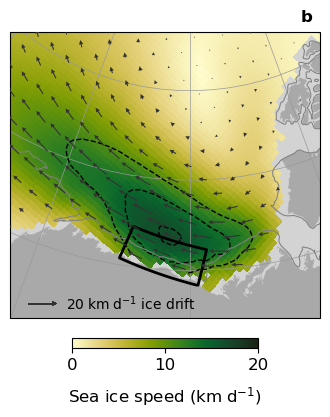

In [212]:
fig, ax = fn.makemap(view='large_view', contours = [], 
                      panels=(1,1), figsize=(4,4))


# fig, ax = fn.makemap(view='wider_zoom2', contours = [], 
#                       panels=(1,1), figsize=(4,4))


FS = 12

ax.add_geometries ([reg_poly], lw=2, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())


line_kwargs = {'lw':0.5, 'c':[0.6,0.6,0.6]}
for lat in np.arange(66,90,4):
    ax.plot(np.linspace(0,359,100), np.full(100,lat), transform=ccrs.PlateCarree(), **line_kwargs)  
for lon in np.arange(0,360,20):
    ax.plot(np.full(100,lon), np.linspace(65,90,100), transform=ccrs.PlateCarree(), **line_kwargs)
    
    
ax.text(0.975,1.025,'b',color='k', size=FS, weight='bold', ha='right', va='bottom', clip_on=False,transform=ax.transAxes)


key = 'all'
sp = 1
u1 = np.nanmean(drift_map[key]['u'], axis=0)*units('cm/s').to('km/day').magnitude
v1 = np.nanmean(drift_map[key]['v'], axis=0)*units('cm/s').to('km/day').magnitude
s1 = np.nanmean(np.sqrt(drift_map[key]['u']**2+drift_map[key]['v']**2), axis=0)*units('cm/s').to('km/day').magnitude
sm = np.sqrt(u1**2+v1**2)
mesh = ax.pcolormesh(drift_map[key]['xx'][::sp,::sp], drift_map[key]['yy'][::sp,::sp], sm[::sp,::sp], 
             vmin=0, vmax=20, transform=drift_map[key]['proj'], cmap=cmocean.cm.speed)

# vector difference
key2 = 'comp'
u2 = np.nanmean(drift_map[key2]['u'], axis=0)*units('cm/s').to('km/day').magnitude
v2 = np.nanmean(drift_map[key2]['v'], axis=0)*units('cm/s').to('km/day').magnitude
vec_diff = np.sqrt((u1-u2)**2+(v1-v2)**2)
# ax.contourf(drift_map[key]['xx'][::sp,::sp], drift_map[key]['yy'][::sp,::sp], vec_diff[::sp,::sp], 
#                  levels=[10,100], colors=['k'], linestyles='dashed', alpha=0.05, linewidths=1, transform=drift_map[key]['proj'])
ax.contour(drift_map[key]['xx'][::sp,::sp], drift_map[key]['yy'][::sp,::sp], vec_diff[::sp,::sp], 
                 levels=[9,11,13], colors=['k'], linestyles='dashed', linewidths=1, transform=drift_map[key]['proj'])


# sp = 1
# ax.scatter(drift_map[key]['xx'][::sp,::sp][vec_diff[::sp,::sp]>11], 
#            drift_map[key]['yy'][::sp,::sp][vec_diff[::sp,::sp]>11],
#            c='k', s=1, transform=drift_map[key]['proj'])



sp = 4
u1 = 7*np.nanmean(drift_map[key]['u'], axis=0)*units('cm/s').to('m/day').magnitude
v1 = 7*np.nanmean(drift_map[key]['v'], axis=0)*units('cm/s').to('m/day').magnitude
Q = ax.quiver(drift_map[key]['xx'][::sp,::sp], drift_map[key]['yy'][::sp,::sp], u1[::sp,::sp], v1[::sp,::sp], 
          angles='xy', scale_units='xy', transform=drift_map[key]['proj'],
          scale=1, width=0.0035, headwidth=4,headlength=4, headaxislength=4, color=[0.2,0.2,0.2], pivot='tail', zorder=100)

qk = ax.quiverkey(Q, X=0.15, Y=0.05, U=7*20000, label='$\mathrm{20\;km\;d^{-1}}$ ice drift', labelpos='E', coordinates='axes')


plotter.add_colorbar(fig, ax, [mesh], cb_placement='bottom', cb_orientation='auto', 
                     cb_width=0.025, cb_length_fraction=[0.2, 0.8], cb_pad=0.05, cb_ticks=[0,10,20], 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='\nSea ice speed ($\mathrm{km\;d^{-1}}$)', labelpad=-5, 
                     cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
                     cb_labelsize=FS, draw_edges=False, edge_params=['k', 2])

# plotter.add_colorbar(fig, ax, [mesh], cb_placement='top', cb_orientation='auto', 
#                      cb_width=0.025, cb_length_fraction=[0.2, 0.8], cb_pad=0.05, cb_ticks=[1000, 1020,1030], 
#                      cb_ticklabels='auto', cb_extend='neither', cb_label='Sea level pressure (hPa)\n', labelpad=-5, 
#                      cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
#                      cb_labelsize=FS, draw_edges=False, edge_params=['k', 2])


ax.contour(dsb.xx, dsb.yy, dsb.avg, levels=[-100], 
           colors=['gray'],linewidths=[0.75],linestyles='solid', transform=dsic['proj'])

fig.savefig('../figures/results/composite_wide_ice.png', dpi=400, bbox_inches='tight', pad_inches=0)


In [492]:
# theta = np.linspace(0, 2*np.pi, 100)
# center, radius = [0.5, 0.5], 0.5
# verts = np.vstack([np.sin(theta), np.cos(theta)]).T
# circle = mpath.Path(verts * radius + center)

# ax.set_boundary(circle, transform=ax.transAxes)
    



(471, 361, 361)

In [458]:
import matplotlib.path as mpath

In [465]:
fig.savefig('../figures/results/composite_wide.png', dpi=400, bbox_inches='tight', pad_inches=0)


In [293]:
drift_map[key]['xx'][a,b]

-1378713.875

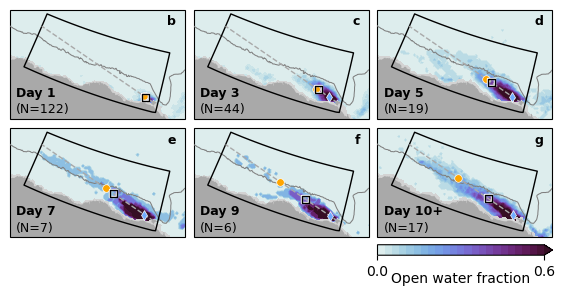

In [790]:
fig, axs = fn.makemap(view='wider_zoom2', contours = [-100], 
                      panels=(2,3), figsize=(7,3.))
plt.subplots_adjust(hspace=0.05, wspace=0.05)


from pyproj import Geod
g = Geod(ellps='WGS84')
# startlon, startlat = -139, 69.5
startlon, startlat = -139.1, 69.6
# dists = np.array([31,64,79, 101,117,134,144,150])+10
# iced = np.array([50.82842169,  68.58080734,  90.47338417,
#         98.24958483, 120.57204264, 128.47181612])
wind = np.array([35.50381821,  75.51196037, 125.48660916, 171.30080786,
       205.45987047, 226.16189264])
latt = np.array([29.89207331, 32.11730528, 33.0155933 , 35.32942831, 28.70799943,
       30.70865801])
obss = np.array([29.38230774,  68.75966641, 106.3567456 , 143.28681747,
       114.46666782, 118.17654774])

# wind = np.array([29.67029984, 81.62365485, 159.8473894, 174.82151541])
# latt = np.array([29.93782605, 33.22366475,  35.32942831, 33.74427032])
# obss = np.array([29.38230774, 76.14685572, 107.23015109, 83.90562419])

# for key, n, N in zip(['Dec', 'Jan', 'Feb', 'Mar',],
#                      [0,2,4,6], [1,3,5,7]):

FS = 9
for key, n in zip([f'd{m}' for m in [1,3,5,7,9]]+[f'd10+'],
                     range(6)):

    axs[n].text(0.95,0.95,f'{chr(97+n+1)}', weight='bold', 
                ha='right', va='top', size=FS, transform=axs[n].transAxes)
    
    ax = axs[n]
    
    ax.add_geometries ([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())
    
    ax.text(0.035,0.175,f'Day {key[1:]}', weight='bold', ha='left', va='bottom', transform=ax.transAxes, size=FS)
    ax.text(0.035,0.025,f'(N={len(event_dates[key])})', ha='left', va='bottom', transform=ax.transAxes, size=FS)
    
#     mesh = ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
#               vmin=0, vmax=0.6, cmap=cmocean.cm.dense, transform=dsic['proj'])
    
    mesh = ax.contourf(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
          vmin=0, vmax=0.6, levels = np.arange(0,0.6,0.025), extend='max', cmap=cmocean.cm.dense, transform=dsic['proj'])
    
#     mesh = ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['sic_mean'], 
#               vmin=0, vmax=100, cmap=cmocean.cm.ice, transform=dsic['proj'])
    
#     ax.contour(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
#                   levels=[0.25, 0.5], colors=['gold'], linewidths=[0.5,], transform=dsic['proj'])
    
    
    endlon, endlat, backaz = g.fwd(startlon, startlat, -55, 400*1000)
    ax.plot([startlon,endlon], [startlat,endlat], transform=ccrs.PlateCarree(), 
            c='darkgray', lw=1, zorder=100, ls='dashed')
    
    endlon, endlat, backaz = g.fwd(startlon, startlat, -55, latt[n]*1000)
    ax.scatter(endlon, endlat, transform=ccrs.PlateCarree(), 
               s=25, marker='d', facecolor=[111/255,171/255,255/255], edgecolor='white',lw=0.5, zorder=100)
    
    
#     endlon, endlat, backaz = g.fwd(startlon, startlat, -55, iced[n]*1000)
#     ax.scatter(endlon, endlat, transform=ccrs.PlateCarree(), 
#                s=30, marker='o', facecolor='r', edgecolor='white', lw=0.5, zorder=100)
    
    endlon, endlat, backaz = g.fwd(startlon, startlat, -55, wind[n]*1000)
    ax.scatter(endlon, endlat, transform=ccrs.PlateCarree(), 
               s=30, marker='o', facecolor='orange', edgecolor='white', lw=0.5, zorder=100)
    
    
    endlon, endlat, backaz = g.fwd(startlon, startlat, -55, obss[n]*1000)
    ax.scatter(endlon, endlat, transform=ccrs.PlateCarree(), 
               s=25, marker='s', edgecolor='white', facecolor='None',lw=1.75, 
               zorder=100)
    ax.scatter(endlon, endlat, transform=ccrs.PlateCarree(), 
               s=25, marker='s', edgecolor='k', facecolor='None', lw=1, zorder=100)

#     ax.scatter(startlon, startlat, transform=ccrs.PlateCarree())
    
plotter.add_colorbar(fig, axs[5], [mesh], cb_placement='bottom', cb_orientation='auto', 
                     cb_width=0.035, cb_length_fraction=[0, 1], cb_pad=0.025, cb_ticks=[0,0.6], 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='Open water fraction', labelpad=-5, 
                     cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
                     cb_labelsize=FS+1, draw_edges=False, edge_params=['k', 2])


# fig.savefig('../figures/results/dailyevent_maps.png', dpi=400, bbox_inches='tight', pad_inches=0)


In [19]:

M = {}
for mooring in ['M1', 'M2', 'M3', 'M4']:  
    M[mooring] = {}
    
    open_years = '2017_2018'
    path = '/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/'
    with xr.open_dataset(path+f"{mooring}/{mooring}_hourly_ocean_currents_{open_years}.nc") as ds:
        M[mooring]['lat'] = ds.lat
        M[mooring]['lon'] = ds.lon

        
# # create false M0 mooring along shelf current
# M['M0'] = {}
# shelf_angle = 145
# # shelf_angle = 165
# shelf_az = 90-shelf_angle
# M['M0']['lon'], M['M0']['lat'], backaz = g.fwd(M['M1']['lon'], M['M1']['lat'], shelf_az, 80000)

In [92]:
all_u10 = dfb['u10'][dfb['sequence']!=-999]
all_v10 = dfb['v10'][dfb['sequence']!=-999]

all_ui = dfb['ui'][dfb['sequence']!=-999]
all_vi = dfb['vi'][dfb['sequence']!=-999]

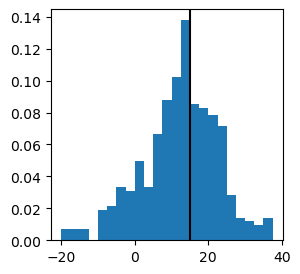

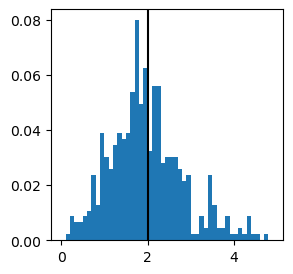

In [93]:

all_ta = np.array([])
all_wf = np.array([])
for U10,V10,UI,VI in zip(all_u10, all_v10, all_ui, all_vi):
    ta = vectors.turning_angle((U10,V10), (UI,VI)).magnitude
    all_ta = np.append(all_ta, ta)
        
    wf = np.sqrt(UI**2+VI**2)/np.sqrt(U10**2+V10**2)
    all_wf = np.append(all_wf, wf)
    
h=plotter.quick_hist(all_ta, bin_edges=np.arange(-20,40,2.5))
fig, ax = plt.subplots(figsize=(3,3))
plt.bar(h['centers'], h['prob'], width=h['w'])
plt.axvline(15, c='k')


h=plotter.quick_hist(all_wf, bin_edges=np.arange(0,5,0.1))
fig, ax = plt.subplots(figsize=(3,3))
plt.bar(h['centers'], h['prob'], width=h['w'])
plt.axvline(2, c='k')

4540    2017-12-03
4541    2017-12-04
4542    2017-12-05
4543    2017-12-06
4544    2017-12-07
4545    2017-12-08
4546    2017-12-09
4547    2017-12-10
4548    2017-12-11
4549    2017-12-12
4550    2017-12-13
4551    2017-12-14
4552    2017-12-15
4553    2017-12-16
4554    2017-12-17
4555    2017-12-18
4556    2017-12-19
4557    2017-12-20
4558    2017-12-21
4559    2017-12-22
4560    2017-12-23
4561    2017-12-24
4562    2017-12-25
4563    2017-12-26
4564    2017-12-27
Name: time, dtype: object
DatetimeIndex(['2017-12-03', '2017-12-04', '2017-12-05', '2017-12-06',
               '2017-12-07', '2017-12-08', '2017-12-09', '2017-12-10',
               '2017-12-11', '2017-12-12', '2017-12-13', '2017-12-14',
               '2017-12-15', '2017-12-16', '2017-12-17', '2017-12-18',
               '2017-12-19', '2017-12-20', '2017-12-21', '2017-12-22',
               '2017-12-23'],
              dtype='datetime64[ns]', freq=None)


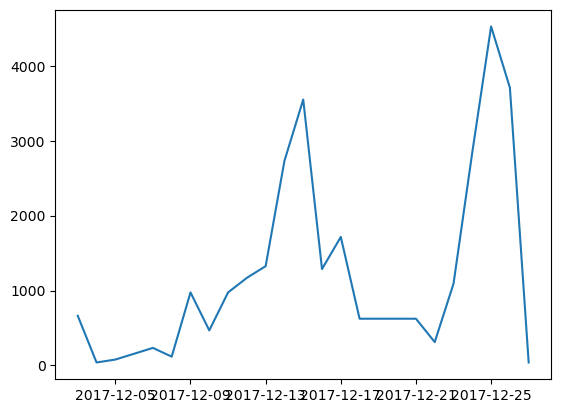

In [134]:
from pyproj import Geod
g = Geod(ellps='WGS84')



# 2024
# SS = 147




# Dec 2017
# SS = 95

#2019
# SS = 106
# SS = 116

# 2025
# SS = 157

# SS = 12

print(df['time'][df['sequence']==SS])

u10_during = df['ui'][df['sequence']==SS]
v10_during = df['vi'][df['sequence']==SS]
time_during = pd.to_datetime(df['time'][df['sequence']==SS].values)
extent_during = df['extent'][df['sequence']==SS]

plt.plot(time_during, extent_during)

print(time_during[:-4])

In [60]:
# average event
u10_during = dfr['u10'][dfr['sequence']==SS]
v10_during = dfr['v10'][dfr['sequence']==SS]
time_during = pd.to_datetime(dfr['time'][dfr['sequence']==SS].values)
extent_during = dfr['extent'][dfr['sequence']==SS]

In [773]:
# open daily drify data
# dl = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/ERA5/hourly_t2m/ERA5_T2m_hourly_2019.nc')
di = xr.open_dataset('/Volumes/Jewell_EasyStore/NSIDC-0116_PPdrift/icemotion_daily_nh_25km_20170101_20171231_v4.1.nc')
# time_during = dd.time

points = {}

In [200]:
# time_range = slice(datetime(2017, 12, 22), datetime(2017, 12, 25,12))


# time_range = slice(datetime(2017, 12, 19, 12), datetime(2017, 12, 26,12))
# open_years = '2017_2018'

# time_range = slice(datetime(2019, 1, 13, 0), datetime(2019, 1, 18,12))
# open_years = '2018_2019'



time_range = slice(datetime(2024, 1, 2, 0), datetime(2024, 1, 14,12))
open_years = '2023_2024'



# time_range = slice(datetime(2016, 12, 15, 12), datetime(2016, 12, 19,12))
# open_years = '2016_2017'


times = pd.to_datetime(pd.date_range(time_range.start, time_range.stop, freq='1H'))

# open hourly data
# dl = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/ERA5/hourly_t2m/ERA5_T2m_hourly_2017.nc')
dw = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/hourly/ERA5_{time_range.stop.year}.nc').sel(time=time_range)
# time_during = dw.time



KeyError: "'time' is not a valid dimension or coordinate"

In [195]:
times

DatetimeIndex(['2024-01-04 00:00:00', '2024-01-04 01:00:00',
               '2024-01-04 02:00:00', '2024-01-04 03:00:00',
               '2024-01-04 04:00:00', '2024-01-04 05:00:00',
               '2024-01-04 06:00:00', '2024-01-04 07:00:00',
               '2024-01-04 08:00:00', '2024-01-04 09:00:00',
               ...
               '2024-01-14 03:00:00', '2024-01-14 04:00:00',
               '2024-01-14 05:00:00', '2024-01-14 06:00:00',
               '2024-01-14 07:00:00', '2024-01-14 08:00:00',
               '2024-01-14 09:00:00', '2024-01-14 10:00:00',
               '2024-01-14 11:00:00', '2024-01-14 12:00:00'],
              dtype='datetime64[ns]', length=253, freq='H')

In [201]:
# ppd = icedrift.open_local_file(times, main_path='/Volumes/Jewell_EasyStore/NSIDC-0116_PPdrift/', 
#                          filenametype='icemotion_daily_nh_25km_{}0101_{}1231_v4.1.nc', 
#                          crop=[0, None, 0, None], include_units=False)
# ppd['lon'][ppd['lon']>180]-=360

# ppr = xr.open_dataset(f'../data/forcing/regional_daily_ppd_{open_years.split("_")[-1]}_v7.nc')

ppw = xr.open_dataset(f'../data/forcing/regional_daily_era_{open_years.split("_")[-1]}_v7.nc')


In [209]:
icetrack = {}
points = {}

# coords = [(69.9991, -142.2903), (69.9046, -141.7307), (69.7823, -141.3786), 
#           (69.7001, -140.9825), (69.6524, -140.4897), (69.6437, -139.9488),
#           (69.5991, -139.5487), (69.6232, -139.2316), (69.6142, -138.8635),
#           (69.4773, -138.6382), (69.3960, -138.4758), (69.3067, -138.1347), 
#           (69.2568, -137.8408), (69.2197, -137.5207), (69.2626, -137.2099), 
#           (69.3817, -136.9212), (69.4857, -136.6369), (69.5879, -136.2569),
#           (69.6946, -135.8771), (69.7883, -135.5007), (69.8165, -135.0666), 
#           (69.8542, -134.7344), (69.8911, -134.4010), (69.9086, -133.9909), 
#           (69.9057, -133.6826)
#          ]

coords = [(69.6232, -139.2316), 
         ]

initial_lons = np.array([coord[1] for coord in coords])
initial_lats = np.array([coord[0] for coord in coords])

initial_times = np.full(len(coords), time_range.start)


# initial_times = np.concatenate((np.full(5, datetime(2019,1,16)), np.full(len(coords)-5, datetime(2019,1,13,12)) ))
# initial_times = np.concatenate((np.full(5, datetime(2017,12,19)), np.full(len(coords)-5, datetime(2017,12,19)) ))
# initial_times = np.concatenate((np.full(5, datetime(2016,12,15)), np.full(len(coords)-5, datetime(2016,12,15)) ))


counter = 0
for lon, lat in zip(initial_lons, initial_lats):
    
    icetrack[counter] = {}
    icetrack[counter]['lons'] = np.array([lon])
    icetrack[counter]['lats'] = np.array([lat])
    
    icetrack[counter]['e'] = np.array([])
    icetrack[counter]['n'] = np.array([])
    
    
    points[counter] = {}
    points[counter]['lons'] = np.array([lon])
    points[counter]['lats'] = np.array([lat])
    
    points[counter]['u10'] = np.array([])
    points[counter]['v10'] = np.array([])
    
    
    for tt, time in enumerate(times):
        
        if time <= initial_times[counter]:

#             points[counter]['u10'] = np.append(points[counter]['u10'], 0)
#             points[counter]['v10'] = np.append(points[counter]['v10'], 0)
            
#             points[counter]['lons'] = np.append(points[counter]['lons'], points[counter]['lons'][-1])
#             points[counter]['lats'] = np.append(points[counter]['lats'], points[counter]['lats'][-1])
            
            
            icetrack[counter]['e'] = np.append(icetrack[counter]['e'], 0)
            icetrack[counter]['n'] = np.append(icetrack[counter]['n'], 0)
            
            icetrack[counter]['lons'] = np.append(icetrack[counter]['lons'], icetrack[counter]['lons'][-1])
            icetrack[counter]['lats'] = np.append(icetrack[counter]['lats'], icetrack[counter]['lats'][-1])

        else:
#             loc_u = dw.u10.sel(longitude=points[counter]['lons'][-1], 
#                                latitude=points[counter]['lats'][-1], 
#                                time = time_during[tt],
#                                 method="nearest").item() * units('m/s')

#             loc_v = dw.v10.sel(longitude=points[counter]['lons'][-1], 
#                                latitude=points[counter]['lats'][-1], 
#                                time = time_during[tt],
#                                 method="nearest").item() * units('m/s')

#             points[counter]['u10'] = np.append(points[counter]['u10'], loc_u)
#             points[counter]['v10'] = np.append(points[counter]['v10'], loc_v)

#             drift_angle = vectors.vector_angle(loc_u,loc_v) - 35 * units('degree')
#             drift_dist = 0.02 * np.sqrt(loc_u**2+loc_v**2).to('m/hour').magnitude

#             endlon, endlat, backaz = g.fwd(points[counter]['lons'][-1], 
#                                            points[counter]['lats'][-1], 
#                                            90-drift_angle.magnitude, drift_dist)

#             points[counter]['lons'] = np.append(points[counter]['lons'], endlon)
#             points[counter]['lats'] = np.append(points[counter]['lats'], endlat)


#             # find ice drift
            time_no_hour = time - timedelta(hours=time.hour)
#             ti = np.where(pd.to_datetime(ppd['ds'].time.values)==time_no_hour)[0][0]
            
#             cE = ppd['e'][ti,:,:]
#             cN = ppd['n'][ti,:,:]

#             # convert last point to drift projection
#             clon = icetrack[counter]['lons'][-1]
#             clat = icetrack[counter]['lats'][-1]
#             cxx, cyy = ppd['proj'].transform_point(clon, clat, ccrs.PlateCarree())

#             # grab nearest drift values
#             dist = np.sqrt((ppd['xx']-cxx)**2 + (ppd['yy']-cyy)**2)
#             finite = np.isfinite(cE)
#             dist[finite==False] = np.nan

#             E = cE[np.where(dist == np.nanmin(dist))][0]
#             N = cN[np.where(dist == np.nanmin(dist))][0]


#             E = ppr.sel(time = time_no_hour).e.values.item()*units('cm/s').to('m/hour').magnitude
#             N = ppr.sel(time = time_no_hour).n.values.item()*units('cm/s').to('m/hour').magnitude

            E = 0.025 * ppw.sel(time = time_no_hour).u10.values.item()*units('m/s').to('m/hour').magnitude 
            N = 0.025 * ppw.sel(time = time_no_hour).v10.values.item()*units('m/s').to('m/hour').magnitude 


            icetrack[counter]['e'] = np.append(icetrack[counter]['e'], E)
            icetrack[counter]['n'] = np.append(icetrack[counter]['n'], N)


            drift_angle = vectors.vector_angle(E,N) - 20 * units('degree')
            drift_dist = np.sqrt(E**2+N**2)

            endlon, endlat, backaz = g.fwd(icetrack[counter]['lons'][-1], 
                                           icetrack[counter]['lats'][-1], 
                                           90-drift_angle.magnitude, drift_dist)

            icetrack[counter]['lons'] = np.append(icetrack[counter]['lons'], endlon)
            icetrack[counter]['lats'] = np.append(icetrack[counter]['lats'], endlat)
        
    counter+=1

In [169]:
dsc = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_ocean_currents_{open_years}.nc')
dsc.close()
dsc = dsc.sel(time=time_range)

m1_lons = np.array([-139.2582])
m1_lats = np.array([69.7718])

flow_angle = vectors.vector_angle(dsc.u.mean('depth').values,dsc.v.mean('depth').values)
flow_dist = np.sqrt(dsc.u.mean('depth')**2+dsc.v.mean('depth')**2).values * units('m/s').to('m/hour').magnitude

for ff in range(len(flow_angle)):
    endlon, endlat, backaz = g.fwd(m1_lons[-1], 
                                   m1_lats[-1], 
                                   90-flow_angle.magnitude[ff], flow_dist[ff])
    
    m1_lons = np.append(m1_lons, endlon)
    m1_lats = np.append(m1_lats, endlat)

In [214]:

# final flow rate to m/day
U = dsc.sel(time=time_range.stop - timedelta(hours=12)).u.mean('depth').values.item()
V = dsc.sel(time=time_range.stop - timedelta(hours=12)).v.mean('depth').values.item()
flow_angle = vectors.vector_angle(U,V)
flow_dist = np.sqrt(U**2+V**2) * units('m/s').to('m/day').magnitude

endlon, endlat, backaz = g.fwd(m1_lons[0], 
                               m1_lats[0], 
                               90-flow_angle.magnitude, flow_dist)


KeyError: "not all values found in index 'time'. Try setting the `method` keyword argument (example: method='nearest')."

In [207]:

# date = datetime(2017,12,27)
date = time_range.stop

RES = '3125'
crop=[1500, 2050, 480, 700]

sic = unisic.open_local_file(date, res=RES, hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                            crop=crop, coordinates=False, area=False, 
                            include_units=False, quiet=True)


In [244]:
dir_bins = np.array([115., 120., 125., 130., 135., 140., 145., 150., 155., 160., 165.,
       170.])

lens_95 = np.array([ 38.25523663,  55.51080706,  71.71114602, 119.51984847,
       141.88020872, 144.86527646, 203.61409144, 363.14614689,
       284.88229401, 111.02230219,  72.498526  ,  55.10222014])

lens_75 = np.array([ 38.25523663,  40.68988689,  63.12707851,  75.11826304,
        95.33143706,  78.48626059, 122.05656563, 150.79228158,
       128.8387282 ,  60.82560104,  58.66907933,  44.93006196])

edge_lons_95 = np.array([])
edge_lats_95 = np.array([])

edge_lons_75 = np.array([])
edge_lats_75 = np.array([])

for direction, length95, length75 in zip(dir_bins, lens_95, lens_75):

    shelf_endlon, shelf_endlat, backaz = g.fwd(-139.1, 69.6, 
                                   90-direction, length95*1000)
    
    edge_lons_95 = np.append(edge_lons_95, shelf_endlon)
    edge_lats_95 = np.append(edge_lats_95, shelf_endlat)
    
    
    shelf_endlon, shelf_endlat, backaz = g.fwd(-139.1, 69.6, 
                                   90-direction, length75*1000)
    
    edge_lons_75 = np.append(edge_lons_75, shelf_endlon)
    edge_lats_75 = np.append(edge_lats_75, shelf_endlat)

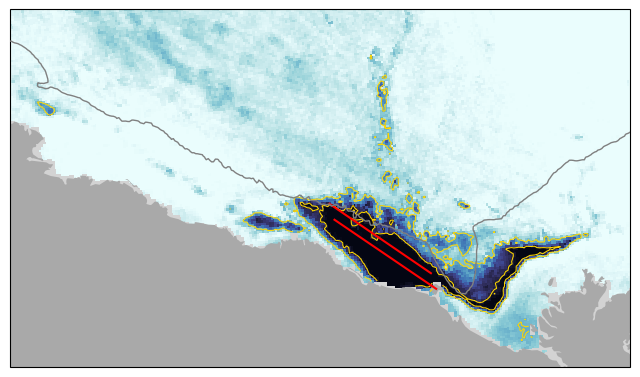

In [415]:
RES = '3125'
crop=[1500, 2050, 480, 700]

sic = unisic.open_local_file(datetime(2025,3,10), res=RES, hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                            crop=crop, coordinates=False, area=False, 
                            include_units=False, quiet=True)
fig, ax = fn.makemap(view='wider_zoom', contours = [-100], figsize=(8,10), panels=(1,1))

    
ax.pcolormesh(sic['xx'], sic['yy'], sic['sic'], vmin=0, vmax=100, transform=sic['proj'], cmap=cmocean.cm.ice)

ax.contour(sic['xx'], sic['yy'], sic['sic'], levels=[10,70], 
           transform=sic['proj'], colors=['gold'], linewidths=0.75)

ax.plot([m1_loc[0],m1_endlon], [m1_loc[1], m1_endlat], transform=ccrs.PlateCarree(), c='r')
ax.plot([HI_loc[0],HI_endlon], [HI_loc[1], HI_endlat], transform=ccrs.PlateCarree(), c='r')


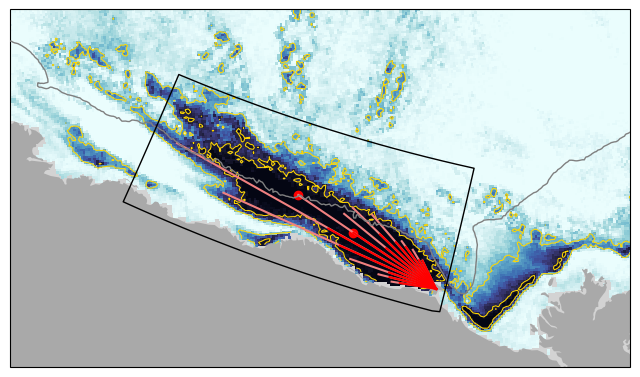

In [246]:
fig, ax = fn.makemap(view='wider_zoom', contours = [-100], figsize=(8,10), panels=(1,1))

    
ax.pcolormesh(sic['xx'], sic['yy'], sic['sic'], vmin=0, vmax=100, transform=sic['proj'], cmap=cmocean.cm.ice)

ax.contour(sic['xx'], sic['yy'], sic['sic'], levels=[10,70], 
           transform=sic['proj'], colors=['gold'], linewidths=0.75)


# for key in icetrack.keys():
#     ax.plot(points[key]['lons'], 
#                points[key]['lats'], transform=ccrs.PlateCarree(), c='b')
    
#     ax.scatter(points[key]['lons'][-1], 
#                points[key]['lats'][-1], transform=ccrs.PlateCarree(), c='b')
#     ax.plot(icetrack[key]['lons'], 
#                icetrack[key]['lats'], transform=ccrs.PlateCarree(), c='r')
    
    
# # ax.plot(m1_lons, m1_lats, transform=ccrs.PlateCarree(), c='orange')

# ax.plot([m1_lons[0], endlon], 
#         [m1_lats[0], endlat], transform=ccrs.PlateCarree(), c='gold')

ax.add_geometries([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())

# ax.plot([-139.1,shelf_endlon], [69.6, shelf_endlat], transform=ccrs.PlateCarree())

for ee_lon, ee_lat in zip(edge_lons_95, edge_lats_95):
    ax.plot([-139.1,ee_lon], [69.6, ee_lat], c='lightcoral', transform=ccrs.PlateCarree())
    
for ee_lon, ee_lat in zip(edge_lons_75, edge_lats_75):
    ax.plot([-139.1,ee_lon], [69.6, ee_lat], c='red', transform=ccrs.PlateCarree())
    
    
ax.scatter([edge_lons_75[np.where(dir_bins == 145)], 
            edge_lons_95[np.where(dir_bins == 145)]], 
           [edge_lats_75[np.where(dir_bins == 145)], 
            edge_lats_95[np.where(dir_bins == 145)]], c='red', transform=ccrs.PlateCarree())

In [399]:
RES = '6250'
crop=[700, 1150, 200, 400]
sic_key = 'sic'
open_thresh = 10

RES = '3125'
crop=[1500, 2050, 480, 700]
sic_key = 'sic'

# RES = '1000ma2'
# crop=[2100, 3400, 340, 800]
# sic_key = 'sic_merged'


sic = unisic.open_local_file(datetime(2019,1,16), res=RES, hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                            crop=crop, coordinates=False, area=False, include_units=False, quiet=True)


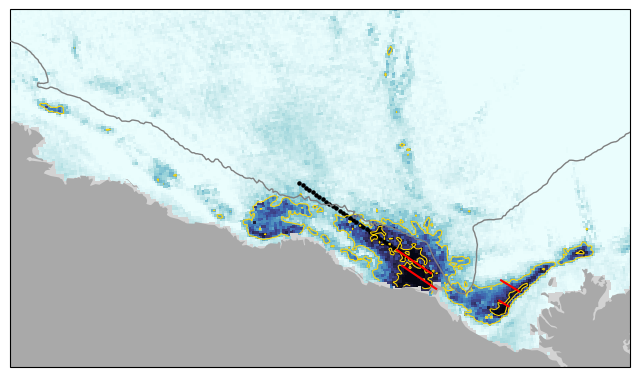

In [404]:
fig, ax = fn.makemap(view='wider_zoom', contours = [-100], figsize=(8,10), panels=(1,1))
ax.patch.set_facecolor('lightgray')
    
ax.pcolormesh(sic['xx'], sic['yy'], sic[sic_key], vmin=0, vmax=100, transform=sic['proj'], cmap=cmocean.cm.ice)

ax.contour(sic['xx'], sic['yy'], sic[sic_key], levels=[10,70], 
           transform=sic['proj'], colors=['gold'], linewidths=0.75)

ax.plot([m1_loc[0],m1_endlon], [m1_loc[1], m1_endlat], transform=ccrs.PlateCarree(), c='r')
ax.plot([HI_loc[0],HI_endlon], [HI_loc[1], HI_endlat], transform=ccrs.PlateCarree(), c='r')


# ax.scatter(track_lons, track_lats, s=5, c='r', transform=ccrs.PlateCarree())


ax.scatter(lon_track, lat_track, s=5, c='k', transform=ccrs.PlateCarree())

other_loc = (-136.8709, 69.3813)
oth_endlon, oth_endlat, backaz = g.fwd(*other_loc, 90-145, 13*1000)
ax.plot([other_loc[0], oth_endlon], [other_loc[1], oth_endlat], c='r', transform=ccrs.PlateCarree())

other_loc = (-136.5081, 69.5365)
oth_endlon, oth_endlat, backaz = g.fwd(*other_loc, 90-145,26*1000)
ax.plot([other_loc[0], oth_endlon], [other_loc[1], oth_endlat], c='r', transform=ccrs.PlateCarree())

In [349]:
az12,az21,dist = g.inv(m1_lons[0],m1_lats[0],m1_endlon,m1_endlat)
# find ten equally spaced points between m1 and final point.
npts = 39
del_s = dist/(npts+1)
print(del_s)
lon_track = np.array([m1_lons[0]])
lat_track = np.array([m1_lats[0]])
r = g.fwd_intermediate(m1_lons[0],m1_lats[0],90-145,npts=npts,del_s=del_s)
for lon,lat in zip(r.lons, r.lats):
    lon_track = np.append(lon_track, lon)
    lat_track = np.append(lat_track, lat)

4999.999999999996


/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/pyproj/geod.py:829: UserWarning: Back azimuth is being returned by default to be compatible with inv()This is a breaking change for pyproj 3.5+.To avoid this warning, set return_back_azimuth=True.Otherwise, to restore old behaviour, set return_back_azimuth=False.This warning will be removed in future version.
  warnings.warn(


In [411]:
m1_loc = (m1_lons[0], m1_lats[0])
HI_loc = (-139.1, 69.6)

m1_endlon, m1_endlat, backaz = g.fwd(*m1_loc, 90-145, 150*1000)
HI_endlon, HI_endlat, backaz = g.fwd(*HI_loc, 90-145, 150*1000)

In [294]:
stepsize = 5
N = 40

In [295]:
track_lons = np.array([m1_loc[0]])
track_lats = np.array([m1_loc[1]])

for n in range(N):
    last_loc = (track_lons[-1], track_lats[-1])
    out = g.fwd(*last_loc, 90-145, stepsize*1000)
    track_lons = np.append(track_lons, out[0])
    track_lats = np.append(track_lats, out[1])

In [296]:
lens_95[np.where(dir_bins == 145)]

array([203.61409144])

In [243]:
edge_lons_75

[-139.52156819709256,
 -139.63062343033903,
 -140.05100095923186,
 -140.3713102543238,
 -140.88218604427558,
 -140.67806279245497,
 -141.74544489486917,
 -142.56183124491835,
 -142.1681577913888,
 -140.58135282853095,
 -140.56523377189288,
 -140.24056570161247]

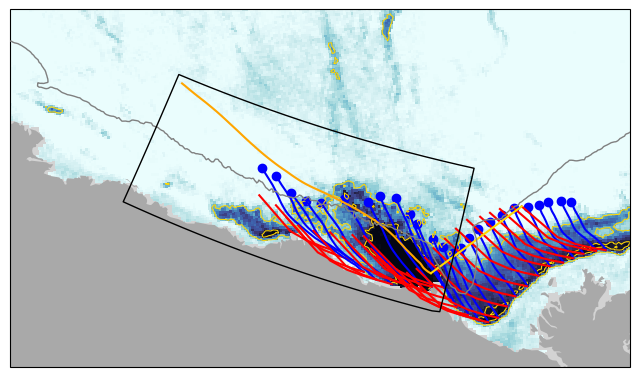

In [177]:
fig, ax = fn.makemap(view='wider_zoom', contours = [-100], figsize=(8,10), panels=(1,1))

    
ax.pcolormesh(sic['xx'], sic['yy'], sic['sic'], vmin=0, vmax=100, transform=sic['proj'], cmap=cmocean.cm.ice)

ax.contour(sic['xx'], sic['yy'], sic['sic'], levels=[10,70], 
           transform=sic['proj'], colors=['gold'], linewidths=0.75)


for key in icetrack.keys():
    ax.plot(points[key]['lons'], 
               points[key]['lats'], transform=ccrs.PlateCarree(), c='b')
    
    ax.scatter(points[key]['lons'][-1], 
               points[key]['lats'][-1], transform=ccrs.PlateCarree(), c='b')
    ax.plot(icetrack[key]['lons'], 
               icetrack[key]['lats'], transform=ccrs.PlateCarree(), c='r')
    
    
ax.plot(m1_lons, m1_lats, transform=ccrs.PlateCarree(), c='orange')

ax.plot([m1_lons[0], endlon], 
        [m1_lats[0], endlat], transform=ccrs.PlateCarree(), c='gold')

ax.add_geometries([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())


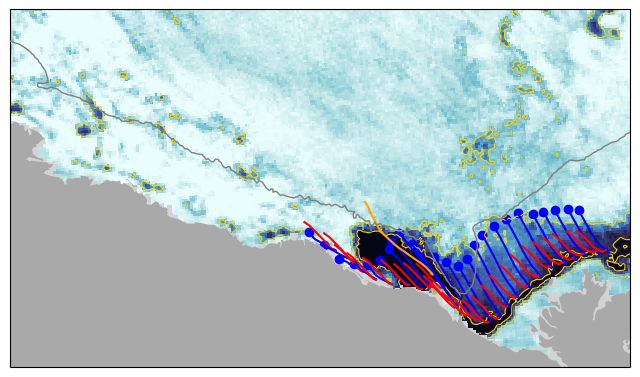

In [66]:
fig, ax = fn.makemap(view='wider_zoom', contours = [-100], figsize=(8,10), panels=(1,1))

    
ax.pcolormesh(sic['xx'], sic['yy'], sic['sic'], vmin=0, vmax=100, transform=sic['proj'], cmap=cmocean.cm.ice)

ax.contour(sic['xx'], sic['yy'], sic['sic'], levels=[10,70], 
           transform=sic['proj'], colors=['gold'], linewidths=0.75)


for key in icetrack.keys():
    ax.plot(points[key]['lons'], 
               points[key]['lats'], transform=ccrs.PlateCarree(), c='b')
    
    ax.scatter(points[key]['lons'][-1], 
               points[key]['lats'][-1], transform=ccrs.PlateCarree(), c='b')
    ax.plot(icetrack[key]['lons'], 
               icetrack[key]['lats'], transform=ccrs.PlateCarree(), c='r')
    
    
ax.plot(m1_lons, m1_lats, transform=ccrs.PlateCarree(), c='orange')


In [ ]:

year = 2024
ds = xr.open_dataset(f'../data/polynya_size/daily_polynya_{year}_sic10_v7.1.nc')

ds.max_length.plot(marker='.')
# ds.max_length_direction.plot()
ds.l_max.plot(marker='.')

In [ ]:
# time_cond = (pd.to_datetime(df.time.values)>=datetime(2023,12,1)) & (pd.to_datetime(df.time.values)<=datetime(2024,4,30))
# time_cond

time_cond = (pd.to_datetime(df.time.values)>=datetime(year-1,12,1)) & (pd.to_datetime(df.time.values)<=datetime(year,4,30))
time_cond

In [ ]:
fig, ax = plt.subplots(figsize=(3,3))

ax.scatter(ds.l_max * ds.w_max-ds.w_min, ds.extent)

plt.xlim(-500,5000)
plt.ylim(-500,5000)

In [1281]:
wa = vectors.vector_angle(df[time_cond].u10.values, df[time_cond].v10.values).magnitude
wa[wa<0]+=360

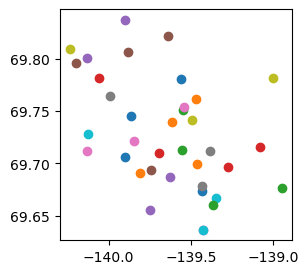

In [1282]:
poly_angles = []
fig, ax = plt.subplots(figsize=(3,3))

for time in ds.time[ds.max_length.values>0].values:
    
    all_xx = ds.poly_interior_xx.sel(time=time).values.item()
    all_yy = ds.poly_interior_yy.sel(time=time).values.item()
    
    xs = np.array(all_xx.split('_')[1:]).astype(float)
    ys = np.array(all_yy.split('_')[1:]).astype(float)
    
    lon, lat = ccrs.PlateCarree().transform_point(np.nanmean(xs), np.nanmean(ys), sic['proj'])
    az, _, dist = g.inv(-139.1, 69.6, lon, lat)
    poly_angles.append(90-az)
    ax.scatter(lon, lat)

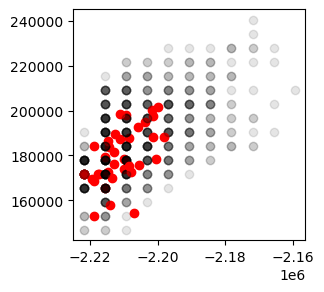

In [1283]:
fig, ax = plt.subplots(figsize=(3,3))
for time in ds.time[ds.max_length.values>0].values:
    
    all_xx = ds.poly_interior_xx.sel(time=time).values.item()
    all_yy = ds.poly_interior_yy.sel(time=time).values.item()
    
    xs = np.array(all_xx.split('_')[1:]).astype(float)
    ys = np.array(all_yy.split('_')[1:]).astype(float)
    
    plt.scatter(xs, ys, c='k', alpha=0.1)
    ax.scatter(np.nanmean(xs), np.nanmean(ys), c='r')

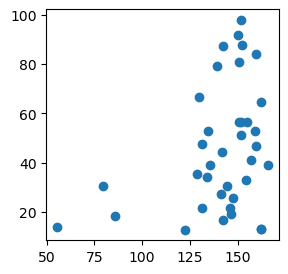

In [1284]:
fig, ax = plt.subplots(figsize=(3,3))
# plt.scatter(ds.max_length_direction.values[ds.max_length.values>0], poly_angles)

# plt.scatter(ds.max_length_direction.values[ds.max_length.values>0], ds.max_length.values[ds.max_length.values>0])
plt.scatter(poly_angles, ds.max_length.values[ds.max_length.values>0])
# plt.scatter(wa[ds.max_length.values>0], poly_angles)

# plt.xlim(80,200)
# plt.ylim(80,200)

# plt.plot([0,360], [0,360])

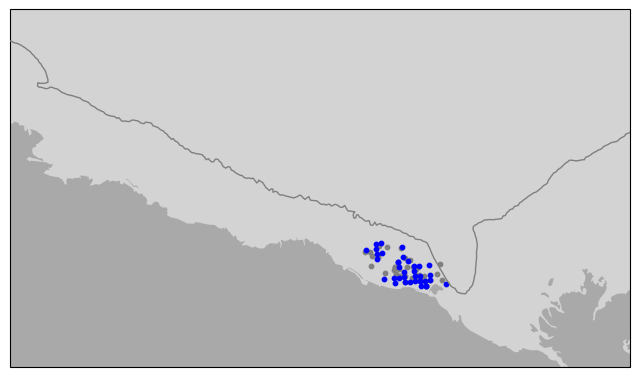

In [1285]:
fig, ax = fn.makemap(view='wider_zoom', contours = [-100], figsize=(8,10), panels=(1,1))

for angle, length in zip(poly_angles, ds.max_length.values[ds.max_length.values>0]):
    lon, lat, _ = g.fwd(-139.1, 69.6, 90-angle, length*1000)
    ax.scatter(lon, lat, transform=ccrs.PlateCarree(), c='gray', s=10)
    
for angle, length in zip(ds.max_length_direction.values[ds.max_length.values>0], 
                         ds.max_length.values[ds.max_length.values>0]):
    lon, lat, _ = g.fwd(-139.1, 69.6, 90-angle, length*1000)
    ax.scatter(lon, lat, transform=ccrs.PlateCarree(), c='b', s=10)
    
# ax.pcolormesh(sic['xx'], sic['yy'], sic['sic'], vmin=0, vmax=100, transform=sic['proj'], cmap=cmocean.cm.ice)

# ax.contour(sic['xx'], sic['yy'], sic['sic'], levels=[10,70], 
#            transform=sic['proj'], colors=['gold'], linewidths=0.75)


In [775]:
time_range = slice(datetime(2017, 12, 22), datetime(2017, 12, 27,12))

# time_range = slice(datetime(2019,1,14,0), datetime(2019,1,21))

# open hourly data
# dl = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/ERA5/hourly_t2m/ERA5_T2m_hourly_2017.nc')
dw = xr.open_dataset('/Volumes/Jewell_EasyStore/ECMWF/annual/hourly/ERA5_2017.nc').sel(time=time_range)
time_during = dw.time

points = {}


points['HI'] = {}
points['HI']['itime'] = time_during[0]
points['HI']['ilat'] =   69.64
points['HI']['ilon'] =   -139.25




points['t1'] = {}
points['t1']['itime'] = time_during[0]
points['t1']['ilat'] =   69.4031
points['t1']['ilon'] =   -136.8446

points['t2'] = {}
points['t2']['itime'] = time_during[0]
points['t2']['ilat'] =   69.5569
points['t2']['ilon'] =   -136.4344


points['t3'] = {}
points['t3']['itime'] = time_during[0]
points['t3']['ilat'] =   69.8133
points['t3']['ilon'] =   -135.4092



points['t4'] = {}
points['t4']['itime'] = time_during[0]
points['t4']['ilat'] =  69.8790
points['t4']['ilon'] =  -133.2463


points['t5'] = {}
points['t5']['itime'] = time_during[0]
points['t5']['ilat'] =  69.4971
points['t5']['ilon'] =  -138.6215

points['t6'] = {}
points['t6']['itime'] = time_during[0]
points['t6']['ilat'] =  69.2833
points['t6']['ilon'] = -137.9395

points['t7'] = {}
points['t7']['itime'] = time_during[0]
points['t7']['ilat'] =  69.2917
points['t7']['ilon'] = -137.0471

points['t8'] = {}
points['t8']['itime'] = time_during[0]
points['t8']['ilat'] =  69.7003
points['t8']['ilon'] = -135.8720



points['t9'] = {}
points['t9']['itime'] = time_during[0]
points['t9']['ilat'] =  69.8940
points['t9']['ilon'] = -134.2445

points['t10'] = {}
points['t10']['itime'] = time_during[0]
points['t10']['ilat'] =  69.6258
points['t10']['ilon'] = -139.7044

points['t11'] = {}
points['t11']['itime'] = time_during[0]
points['t11']['ilat'] =  69.8230
points['t11']['ilon'] = -141.5017


points['t12'] = {}
points['t12']['itime'] = time_during[0]
points['t12']['ilat'] =  69.6970
points['t12']['ilon'] = -140.7146

points['t13'] = {}
points['t13']['itime'] = time_during[0]
points['t13']['ilat'] =  69.115
points['t13']['ilon'] = -137.4817





# points['t4'] = {}
# points['t4']['itime'] = time_during[0]
# points['t4']['ilat'] =   69.6295
# points['t4']['ilon'] =  -140.0593


for key in points.keys():

    points[key]['event_lons'] = np.array([points[key]['ilon']])
    points[key]['event_lats'] = np.array([points[key]['ilat']])
    
    points[key]['u10'] = np.array([])
    points[key]['v10'] = np.array([])
    
    
    points[key]['event_lons_d'] = np.array([points[key]['ilon']])
    points[key]['event_lats_d'] = np.array([points[key]['ilat']])
    
#     points[key]['t2m'] = np.array([])

In [776]:


for tt, time in enumerate(time_during):
    
    for key in points.keys():
    
#         loc_t2m = dl.t2m.sel(longitude=points[key]['event_lons'][tt], 
#                              latitude=points[key]['event_lats'][tt], 
#                              valid_time = time_during[tt],
#                              method="nearest").item() - 273.15

        loc_u = dw.u10.sel(longitude=points[key]['event_lons'][tt], 
                           latitude=points[key]['event_lats'][tt], 
                           time = time_during[tt],
                            method="nearest").item() * units('m/s')

        loc_v = dw.v10.sel(longitude=points[key]['event_lons'][tt], 
                           latitude=points[key]['event_lats'][tt], 
                           time = time_during[tt],
                            method="nearest").item() * units('m/s')
        
#         points[key]['t2m'] = np.append(points[key]['t2m'], loc_t2m)
        points[key]['u10'] = np.append(points[key]['u10'], loc_u)
        points[key]['v10'] = np.append(points[key]['v10'], loc_v)


        drift_angle = vectors.vector_angle(loc_u,loc_v) - 20 * units('degree')
        drift_dist = 0.02 * np.sqrt(loc_u**2+loc_v**2).to('m/hour').magnitude

    #     event_a = np.append(event_a, drift_angle.magnitude)
    #     event_d = np.append(event_d, drift_dist)

        endlon, endlat, backaz = g.fwd(points[key]['event_lons'][-1], 
                                       points[key]['event_lats'][-1], 
                                       90-drift_angle.magnitude, drift_dist)

        points[key]['event_lons'] = np.append(points[key]['event_lons'], endlon)
        points[key]['event_lats'] = np.append(points[key]['event_lats'], endlat)
        
        
        
        # ice velocity data
        time_stip_hour = pd.to_datetime(time.values) - timedelta(hours=pd.to_datetime(time.values).hour)
        time_ind = np.where(pd.to_datetime(df['time'].values) == time_stip_hour)[0][0]

        UI = df['ui'][time_ind] * units('cm/s').to('m/hour')
        VI = df['vi'][time_ind] * units('cm/s').to('m/hour')

        drift_angle = vectors.vector_angle(UI,VI) - 20 * units('degree')
        drift_dist = np.sqrt(UI**2+VI**2).to('m/hour').magnitude

        endlon, endlat, backaz = g.fwd(points[key]['event_lons_d'][-1], 
                                       points[key]['event_lats_d'][-1], 
                                       90-drift_angle.magnitude, drift_dist)
        
        points[key]['event_lons_d'] = np.append(points[key]['event_lons_d'], endlon)
        points[key]['event_lats_d'] = np.append(points[key]['event_lats_d'], endlat)
        
        
        
        df['time']

In [782]:

RES = '6250'
crop=[700, 1150, 200, 400]
# sic_key = 'sic'


RES = '3125'
crop=[1500, 2050, 480, 700]
# sic_key = 'sic'

# datetime(2025,3,11)


# date = datetime(2019,1,18,)

# date = datetime(2025,3,12)

date = datetime(2017,12,26)

sic = unisic.open_local_file(date, res=RES, hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                            crop=crop, coordinates=False, area=False, 
                            include_units=False, quiet=True)

tf = np.where(pd.to_datetime(time_during) == date)[0][0]

In [779]:
# sorted 
start_lons = np.array([points[key]['event_lons_d'][0] for key in points.keys()])
start_lats = np.array([points[key]['event_lats_d'][0] for key in points.keys()])

final_lons = np.array([points[key]['event_lons_d'][tf+12] for key in points.keys()])
final_lats = np.array([points[key]['event_lats_d'][tf+12] for key in points.keys()])

# sorted 
final_lats = final_lats[np.argsort(start_lons)]
final_lons = final_lons[np.argsort(start_lons)]

start_lats = start_lats[np.argsort(start_lons)]
start_lons = start_lons[np.argsort(start_lons)]

In [707]:
dsc = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_ocean_currents_2018_2019.nc')
dsc.close()
dsc = dsc.sel(time=time_range)

In [753]:
dsc = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_ocean_currents_2018_2019.nc')
dsc.close()
dsc = dsc.sel(time=time_range)

m1_lons = np.array([-139.2582])
m1_lats = np.array([69.7718])


flow_angle = vectors.vector_angle(dsc.u.mean('depth').values,dsc.v.mean('depth').values) #- 20 * units('degree')
flow_dist = np.sqrt(dsc.u.mean('depth')**2+dsc.v.mean('depth')**2).values * units('m/s').to('m/hour').magnitude

#     event_a = np.append(event_a, drift_angle.magnitude)
#     event_d = np.append(event_d, drift_dist)

for ff in range(len(flow_angle)):
    endlon, endlat, backaz = g.fwd(m1_lons[-1], 
                                   m1_lats[-1], 
                                   90-flow_angle.magnitude[ff], flow_dist[ff])
    
    m1_lons = np.append(m1_lons, endlon)
    m1_lats = np.append(m1_lats, endlat)

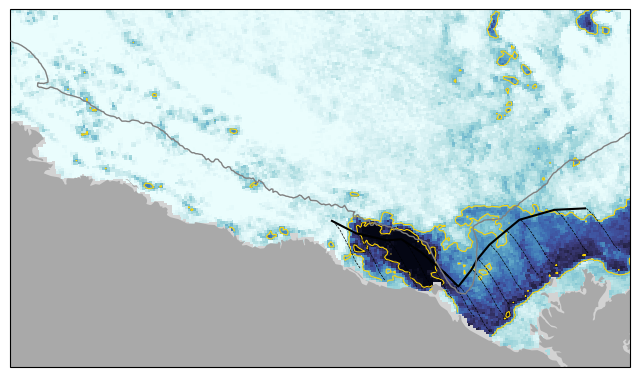

In [783]:
fig, ax = fn.makemap(view='wider_zoom', contours = [-100], figsize=(8,10), panels=(1,1))



ax.pcolormesh(sic['xx'], sic['yy'], sic['sic'], vmin=0, vmax=100, transform=sic['proj'], cmap=cmocean.cm.ice)

ax.contour(sic['xx'], sic['yy'], sic['sic'], levels=[10,70], 
           transform=sic['proj'], colors=['gold'], linewidths=0.75)


# iter_dates = pd.date_range(datetime(2019,1,14), datetime(2019,1,18))
# iter_colors = ['b', 'dodgerblue', 'lightcoral', 'r', 'gold']


# for date, color in zip(iter_dates, iter_colors):

#     sic = unisic.open_local_file(date, res=RES, hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
#                                 crop=crop, coordinates=False, area=False, 
#                                 include_units=False, quiet=True)
    
# #     ax.contour(sic['xx'], sic['yy'], sic['sic'], levels=[10,70], 
# #            transform=sic['proj'], colors=['r', 'b'], linewidths=0.75)

#     ax.contour(sic['xx'], sic['yy'], sic['sic'], levels=[10], 
#            transform=sic['proj'], colors=[color], linewidths=0.75)



for key in points.keys():
    ax.plot(points[key]['event_lons_d'][:tf+12], 
            points[key]['event_lats_d'][:tf+12], transform=ccrs.PlateCarree(), c='k', lw=0.5, ls='dashed')

# #     ax.scatter(points[key]['event_lons'][0], 
# #                 points[key]['event_lats'][0], transform=ccrs.PlateCarree(), c='r')
    
# #     ax.scatter(points[key]['event_lons'][tf+12], 
# #                 points[key]['event_lats'][tf+12], transform=ccrs.PlateCarree(), c='r')
    
    
# #     ax.scatter(points[key]['event_lons'][::24], 
# #             points[key]['event_lats'][::24], transform=ccrs.PlateCarree(), c='r')


# ax.scatter(m1_lons[::24], m1_lats[::24], transform=ccrs.PlateCarree(), c='b')


ax.plot(final_lons, final_lats, transform=ccrs.PlateCarree(), c='k')
# ax.plot(start_lons, start_lats, transform=ccrs.PlateCarree(), c='r')


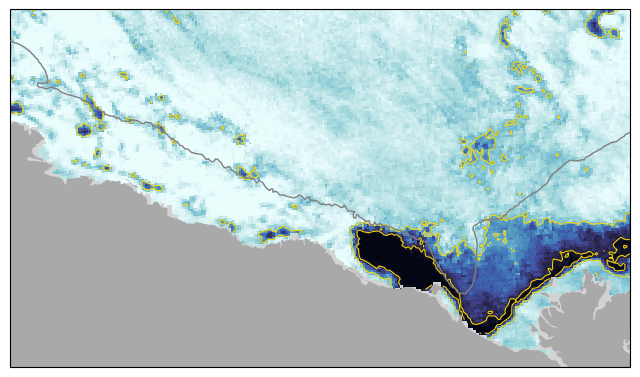

In [784]:
# date = datetime(2019,1,18,)

# date = datetime(2024,1, 14,)

# date = datetime(2025,3,12)

date = datetime(2017,12,25)

sic = unisic.open_local_file(date, res=RES, hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                            crop=crop, coordinates=False, area=False, 
                            include_units=False, quiet=True)


fig, ax = fn.makemap(view='wider_zoom', contours = [-100], figsize=(8,10), panels=(1,1))
ax.pcolormesh(sic['xx'], sic['yy'], sic['sic'], vmin=0, vmax=100, transform=sic['proj'], cmap=cmocean.cm.ice)

ax.contour(sic['xx'], sic['yy'], sic['sic'], levels=[10,70], 
           transform=sic['proj'], colors=['gold'], linewidths=0.75)

In [619]:
# time_range = slice(datetime(2018, 1, 1), datetime(2018, 1, 31,23))

time_range = slice(datetime(2017, 1, 1), datetime(2017, 1, 31,23))

# open hourly data
# dl = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/ERA5/hourly_t2m/ERA5_T2m_hourly_2017.nc')
dw = xr.open_dataset('/Volumes/Jewell_EasyStore/ECMWF/annual/hourly/ERA5_2017.nc').sel(time=time_range)


In [494]:
# time_range = slice(datetime(2017,12,22,18), datetime(2017, 12, 26,20))

# time_range = slice(datetime(2017,12,22,18), datetime(2017, 12, 26,20))

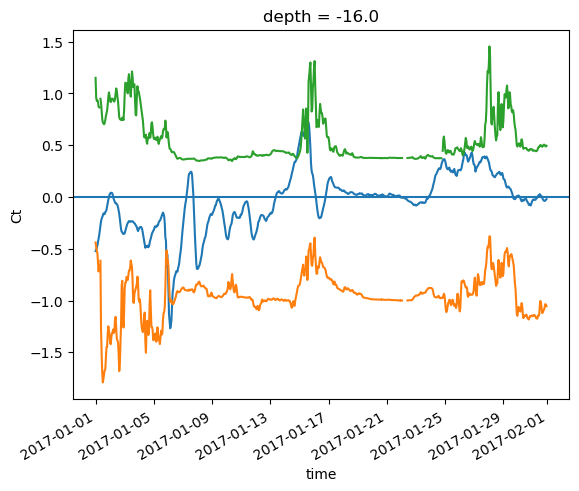

In [629]:
ds1 = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_ocean_currents_2016_2017.nc')
ds1 = ds1.sel(time = time_range)
ds1['ese'] = vectors.comp_along_theta(ds1.u, ds1.v, 145*units('degree'))

ds1o = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_tempsalinity_2016_2017.nc')
ds1o = ds1o.sel(time = time_range)


(ds1.ese.mean('depth')).plot()
# ((ds1o.sig0.mean('depth')-26)/2).plot()
((ds1o.sig0.sel(depth=-16)-26)/2).plot()
# ((ds1o.Ct.mean('depth'))+2).plot()
((ds1o.Ct.sel(depth=-16))+2).plot()

plt.axhline(0)

In [631]:
tracks = {}

use_m = ['M1', 'M2', 'M3', 'M4']

for M in use_m:
    
    tracks[M] = {}
    
    ds1 = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{M}/{M}_hourly_seaice_velocity_2016_2017.nc')
    ds1 = ds1.sel(time=time_range)
    ds1['ese'] = vectors.comp_along_theta(ds1.u, ds1.v, 145*units('degree'))
    tracks[M]['ds'] = ds1
    
    
    tracks[M]['lons'] = np.array([tracks[M]['ds'].attrs['lon']])
    tracks[M]['lats'] = np.array([tracks[M]['ds'].attrs['lat']])
    
    if M == 'M2':
        tracks[M]['lons'] = np.array([-136.7702])
        tracks[M]['lats'] = np.array([69.3152])
        
    if M == 'M3':
        tracks[M]['lons'] = np.array([-136.4361])
        tracks[M]['lats'] = np.array([69.4670])
        
    if M == 'M4':
        tracks[M]['lons'] = np.array([-135.6528])
        tracks[M]['lats'] = np.array([69.6423])
        
    
    all_u = tracks[M]['ds'].sel(depth=0).u.values
    all_v = tracks[M]['ds'].sel(depth=0).v.values
    times = pd.to_datetime(tracks[M]['ds'].time.values)

    # interpolate over missing data
    interp_u, _ = tseries.linear_interpolate(times, times, all_u, max_dt=6*units('hour'))
    interp_v, _ = tseries.linear_interpolate(times, times, all_v, max_dt=6*units('hour'))

    tracks[M]['u'] = interp_u
    tracks[M]['v'] = interp_v
    

    for tt, time in enumerate(times):
#         curr_ds = tracks[M]['ds'].sel(time=time, depth=0)
        drift_angle = vectors.vector_angle(interp_u[tt],interp_v[tt]) #- 20 * units('degree')
        drift_dist = np.sqrt(interp_u[tt]**2+interp_v[tt]**2)*units('m/s').to('m/hour').magnitude

        endlon, endlat, backaz = g.fwd(tracks[M]['lons'][-1], 
                                       tracks[M]['lats'][-1], 
                                       90-drift_angle.magnitude, drift_dist)

        tracks[M]['lons'] = np.append(tracks[M]['lons'], endlon)
        tracks[M]['lats'] = np.append(tracks[M]['lats'], endlat)

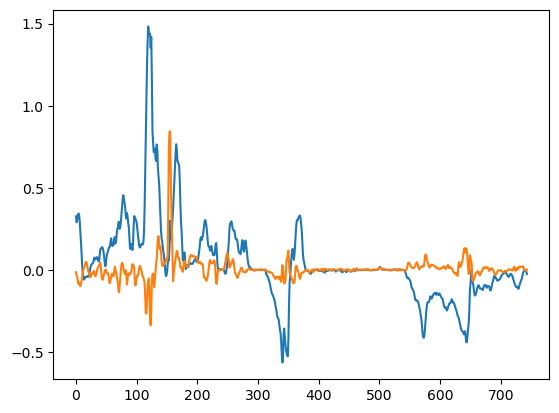

In [643]:
all_u = np.concatenate((tracks['M2']['u'], tracks['M3']['u'], tracks['M4']['u']))
all_v = np.concatenate((tracks['M2']['v'], tracks['M3']['v'], tracks['M4']['v']))

u_grid = np.reshape(all_u, (3,len(tracks['M2']['u'])))
v_grid = np.reshape(all_v, (3,len(tracks['M2']['v'])))

# regional_u = np.nanmean(u_grid, axis=0)
# regional_v = np.nanmean(v_grid, axis=0)

regional_u = u_grid[0,:]
regional_v = v_grid[0,:]

plt.plot(regional_u)
plt.plot(regional_v)


In [644]:
tracks2 = {}

initial_lons = np.array([-136.4080, -135.8647, -135.289])
initial_lats = np.array([69.4635, 69.5732, 69.7071])

counter = 0
for lon, lat in zip(initial_lons, initial_lats):
    
    tracks2[counter] = {}
    tracks2[counter]['lons'] = np.array([lon])
    tracks2[counter]['lats'] = np.array([lat])
    
    for tt, time in enumerate(times):
        drift_angle = vectors.vector_angle(regional_u[tt],regional_v[tt])
        drift_dist = np.sqrt(regional_u[tt]**2+regional_v[tt]**2)*units('m/s').to('m/hour').magnitude

        endlon, endlat, backaz = g.fwd(tracks2[counter]['lons'][-1], 
                                       tracks2[counter]['lats'][-1], 
                                       90-drift_angle.magnitude, drift_dist)
        
        tracks2[counter]['lons'] = np.append(tracks2[counter]['lons'], endlon)
        tracks2[counter]['lats'] = np.append(tracks2[counter]['lats'], endlat)
        
    counter+=1

In [645]:
dw_event = dw.sel(longitude=-138.75, latitude=69.75, time = time_range)

In [646]:
wind_speed = np.sqrt(dw_event.u10.values**2+dw_event.v10.values**2)
ice_speed = np.sqrt(regional_u**2+regional_v**2)

In [647]:
v1=(dw_event.u10.values, dw_event.v10.values) 
v2=(regional_u,regional_v)
ta = vectors.turning_angle(v1, v2)


wf = (ice_speed/wind_speed)[wind_speed>3]

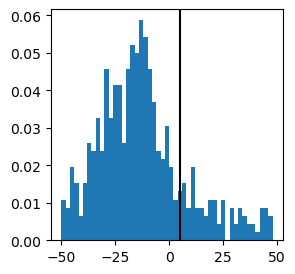

In [648]:
h = plotter.quick_hist(ta.magnitude, bin_edges=np.arange(-50,50,2))

fig, ax = plt.subplots(figsize=(3,3))
plt.bar(h['centers'], h['prob'], width=h['w'])
plt.axvline(5, c='k')

<BarContainer object of 39 artists>

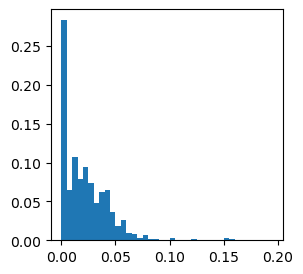

In [649]:
h = plotter.quick_hist(wf, bin_edges=np.arange(0,0.2,0.005))

fig, ax = plt.subplots(figsize=(3,3))
plt.bar(h['centers'], h['prob'], width=h['w'])
# plt.axvline(5, c='k')

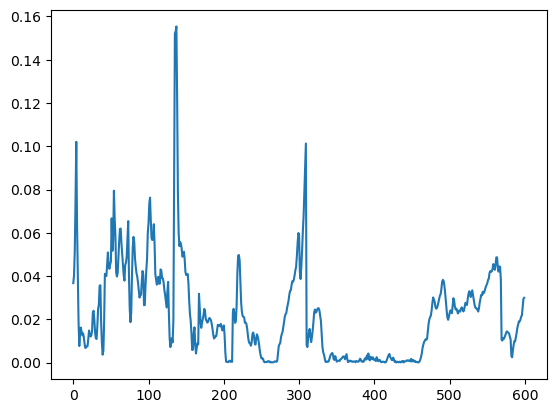

In [650]:
plt.plot(wf)

In [484]:
date = datetime(2017,12,26)

sic = unisic.open_local_file(date, res=RES, hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                            crop=crop, coordinates=False, area=False, 
                            include_units=False, quiet=True)

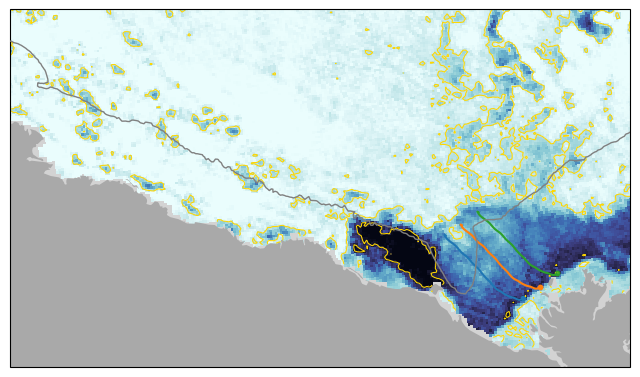

In [487]:
fig, ax = fn.makemap(view='wider_zoom', contours = [-100], figsize=(8,10), panels=(1,1))



ax.pcolormesh(sic['xx'], sic['yy'], sic['sic'], vmin=0, vmax=100, transform=sic['proj'], cmap=cmocean.cm.ice)

ax.contour(sic['xx'], sic['yy'], sic['sic'], levels=[10,90], 
           transform=sic['proj'], colors=['gold'], linewidths=0.75)




# for M in use_m:
#     ax.plot(tracks[M]['lons'], tracks[M]['lats'], transform=ccrs.PlateCarree())
#     ax.scatter(tracks[M]['lons'][0], tracks[M]['lats'][0], s=10, transform=ccrs.PlateCarree())


for c in tracks2.keys():
    ax.plot(tracks2[c]['lons'], tracks2[c]['lats'], transform=ccrs.PlateCarree())
    ax.scatter(tracks2[c]['lons'][0], tracks2[c]['lats'][0], s=10, transform=ccrs.PlateCarree())

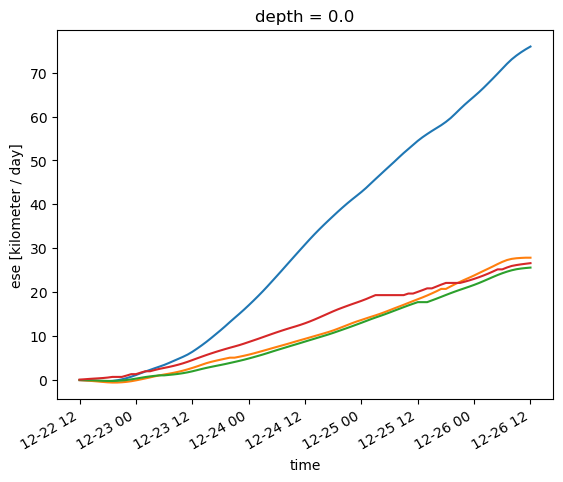

In [332]:
ds1 = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_seaice_velocity_2017_2018.nc')
ds1 = ds1.sel(time=time_range)
ds1['ese'] = vectors.comp_along_theta(ds1.u, ds1.v, 145*units('degree'))

ds2 = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M2/M2_hourly_seaice_velocity_2017_2018.nc')
ds2 = ds2.sel(time=time_range)
ds2['ese'] = vectors.comp_along_theta(ds2.u, ds2.v, 145*units('degree'))

ds3 = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M3/M3_hourly_seaice_velocity_2017_2018.nc')
ds3 = ds3.sel(time=time_range)
ds3['ese'] = vectors.comp_along_theta(ds3.u, ds3.v, 145*units('degree'))

ds4 = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M4/M4_hourly_seaice_velocity_2017_2018.nc')
ds4 = ds4.sel(time=time_range)
ds4['ese'] = vectors.comp_along_theta(ds4.u, ds4.v, 145*units('degree'))


np.cumsum(ds1.ese*units('cm/s').to('km/day')).plot()
np.cumsum(ds2.ese*units('cm/s').to('km/day')).plot()
np.cumsum(ds3.ese*units('cm/s').to('km/day')).plot()
np.cumsum(ds4.ese*units('cm/s').to('km/day')).plot()



In [333]:
ds1

<xarray.Dataset>
Dimensions:  (depth: 1, time: 97)
Coordinates:
  * depth    (depth) float64 0.0
  * time     (time) datetime64[ns] 2017-12-22T12:00:00 ... 2017-12-26T12:00:00
Data variables:
    u        (depth, time) float64 0.04794 0.06613 0.09025 ... -0.4802 -0.4094
    v        (depth, time) float64 -0.03283 0.004581 0.0351 ... 0.691 0.6593
    ese      (depth, time) float64 -0.0581 -0.05154 -0.0538 ... 0.7897 0.7135
Attributes:
    lat:      69.7718
    lon:      -139.2582

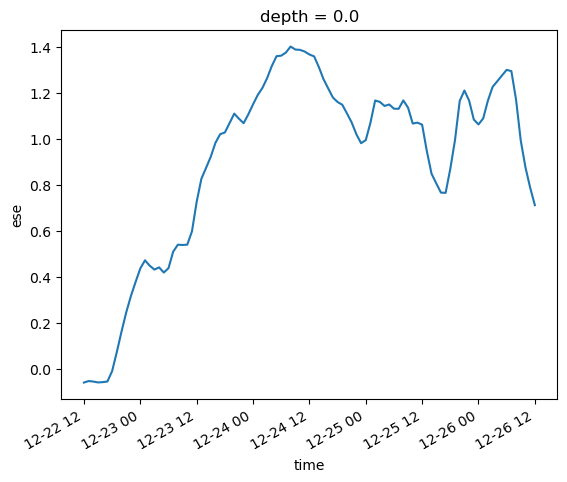

In [334]:
ds1.ese.plot()

In [166]:


# event_a = np.array([])
# event_d = np.array([])

# for uu,vv in zip(u10_during, v10_during):
#     drift_angle = vectors.vector_angle(uu,vv) - 20 * units('degree')
#     drift_dist = 0.02 * np.sqrt(uu**2+vv**2) * units('m/s').to('m/day').magnitude

# #     drift_angle = vectors.vector_angle(uu,vv)
# #     drift_dist = np.sqrt(uu**2+vv**2) * units('cm/s').to('m/day').magnitude
    
#     event_a = np.append(event_a, drift_angle.magnitude)
#     event_d = np.append(event_d, drift_dist)
    

# points = {}

# # points['HI'] = {}
# # points['HI']['itime'] = time_during[0]
# # points['HI']['ilat'] =   69.64
# # points['HI']['ilon'] =   -139.25

# # points['t1'] = {}
# # points['t1']['itime'] = time_during[3]
# # points['t1']['ilat'] =   69.37
# # points['t1']['ilon'] =   -136.89

# # points['t2'] = {}
# # points['t2']['itime'] = time_during[3]
# # points['t2']['ilat'] =   69.66
# # points['t2']['ilon'] =   -136.07

# points['HI'] = {}
# points['HI']['itime'] = time_during[0]
# points['HI']['ilat'] =   69.64
# points['HI']['ilon'] =   -139.25

# points['t1'] = {}
# points['t1']['itime'] = time_during[0]
# points['t1']['ilat'] =   69.2364
# points['t1']['ilon'] =   -137.6210

# points['t2'] = {}
# points['t2']['itime'] = time_during[0]
# points['t2']['ilat'] =   69.5569
# points['t2']['ilon'] =   -136.4344


# points['t3'] = {}
# points['t3']['itime'] = time_during[0]
# points['t3']['ilat'] =   69.8133
# points['t3']['ilon'] =   -135.4092


# points['t4'] = {}
# points['t4']['itime'] = time_during[0]
# points['t4']['ilat'] =   69.6295
# points['t4']['ilon'] =  -140.0593




# for key in points.keys():

#     event_lons = np.array([points[key]['ilon']])
#     event_lats = np.array([points[key]['ilat']])

#     for a, d, time in zip(event_a, event_d, time_during):
        
#         if time >= points[key]['itime']:
#             endlon, endlat, backaz = g.fwd(event_lons[-1], event_lats[-1], 90-a, d)
#         else:
#             endlon, endlat = event_lons[-1], event_lats[-1]
            
#         event_lons = np.append(event_lons, endlon)
#         event_lats = np.append(event_lats, endlat)
        
#     points[key]['event_lons'] = event_lons
#     points[key]['event_lats'] = event_lats

In [95]:
endlon, endlat, backaz = g.fwd(points['HI']['ilon'], points['HI']['ilat'], 90-(145), 100*1000)

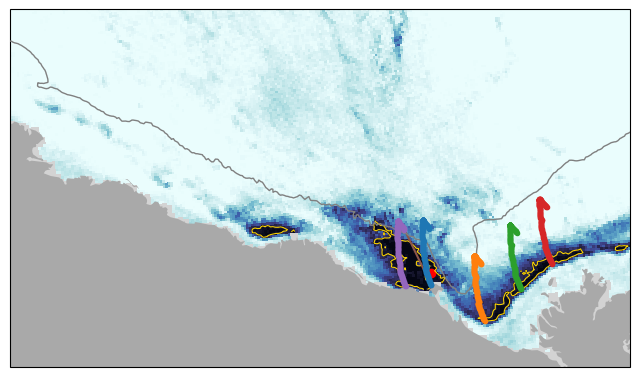

In [170]:
fig, ax = fn.makemap(view='wider_zoom', contours = [-100], figsize=(8,10), panels=(1,1))



for key in points.keys():
    ax.plot(points[key]['event_lons'][:-1], 
               points[key]['event_lats'][:-1], 
               transform=ccrs.PlateCarree(), zorder=100, marker='.')

ax.pcolormesh(sic['xx'], sic['yy'], sic['sic'], vmin=0, vmax=100, transform=sic['proj'], cmap=cmocean.cm.ice)


ax.contour(sic['xx'], sic['yy'], sic['sic'], levels=[10], 
           transform=sic['proj'], colors=['gold'], linewidths=0.75)


ax.plot([points['HI']['ilon'], endlon], 
        [points['HI']['ilat'], endlat], 
           transform=ccrs.PlateCarree())



ax.scatter(-139.2582, 69.7718, c='r', transform=ccrs.PlateCarree())


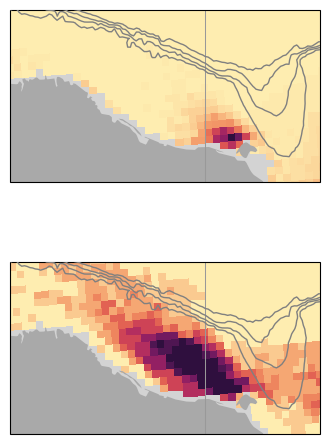

In [35]:
fig, axs = fn.makemap(view='narrowzoom', contours = [-400,-300,-200,-100], figsize=(4,6), panels=(2,1))

for ax in axs:
    line_kwargs = {'lw':0.75, 'c':[0.6,0.6,0.6]}
    for lat in [69,71,73]:
        ax.plot(np.linspace(-160,-120,100), np.full(100,lat), transform=ccrs.PlateCarree(), **line_kwargs)  
    for lon in [-160,-150,-140,-130]:
        ax.plot(np.full(100,lon), np.linspace(68,73,100), transform=ccrs.PlateCarree(), **line_kwargs)


    

key = 'd1'
axs[0].pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
              vmin=0, vmax=0.5, cmap=cmocean.cm.matter, transform=dsic['proj'])

key = 'd6'
axs[1].pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
              vmin=0, vmax=0.5, cmap=cmocean.cm.matter, transform=dsic['proj'])


NameError: name 'reg_poly' is not defined

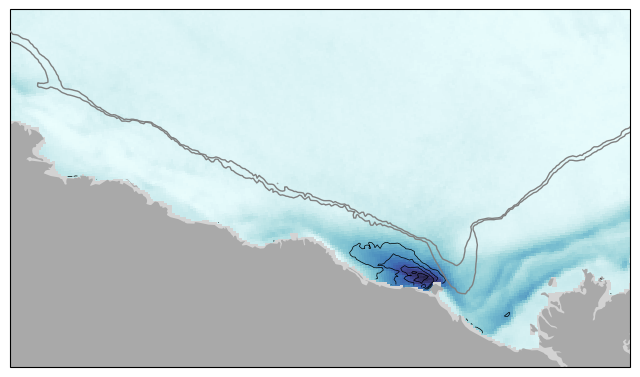

In [14]:
fig, ax = fn.makemap(view='wider_zoom', contours = [-200,-100])


key = 'all'
# key2='comp'

# ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
#               vmin=0, vmax=0.5, cmap=cmocean.cm.haline_r, transform=dsic['proj'])

ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['sic_mean'], 
              vmin=10, vmax=100, cmap=cmocean.cm.ice, transform=dsic['proj'])

ax.contour(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
           levels=[0.1,0.2,0.3,0.4,0.5], colors=['k'], linewidths=0.5, transform=dsic['proj'])


ax.add_geometries([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())


line_kwargs = {'lw':0.75, 'c':[0.6,0.6,0.6]}
for lat in [69,71,73]:
    ax.plot(np.linspace(-160,-120,100), np.full(100,lat), transform=ccrs.PlateCarree(), **line_kwargs)  
for lon in [-160,-150,-140,-130]:
    ax.plot(np.full(100,lon), np.linspace(68,73,100), transform=ccrs.PlateCarree(), **line_kwargs)
    
    





# ax.quiver(drift_map_moor[key]['X_scaled'], drift_map_moor[key]['Y_scaled'], 
#           eS1, nS1, 
#           angles='xy', scale_units='xy', 
#           scale=1, width=0.0035, pivot='tail', zorder=100)

# u1 = np.nanmean(drift_map[key]['u'], axis=0)*units('cm/s').to('m/day').magnitude
# v1 = np.nanmean(drift_map[key]['v'], axis=0)*units('cm/s').to('m/day').magnitude
# ax.quiver(drift_map[key]['xx'], drift_map[key]['yy'], 
#           u1, v1, 
#           angles='xy', scale_units='xy', transform=drift_map[key]['proj'],
#           scale=1, width=0.0035, color='gray', pivot='tail', zorder=100)

# u1 = np.nanmean(drift_map[key]['u'], axis=0)*units('cm/s').to('m/day').magnitude
# v1 = np.nanmean(drift_map[key]['v'], axis=0)*units('cm/s').to('m/day').magnitude
# s1 = np.nanmean(np.sqrt(drift_map[key]['u']**2+drift_map[key]['v']**2), axis=0)*units('cm/s').to('m/day').magnitude

# ax.quiver(drift_map[key]['xx'], drift_map[key]['yy'], 
#           u1, v1, 
#           angles='xy', scale_units='xy', transform=drift_map[key]['proj'],
#           scale=1, width=0.0035, color='gray', pivot='tail', zorder=100)


# u2 = np.nanmean(drift_map[key2]['u'], axis=0)*units('cm/s').to('m/day').magnitude
# v2 = np.nanmean(drift_map[key2]['v'], axis=0)*units('cm/s').to('m/day').magnitude
# s2 = np.nanmean(np.sqrt(drift_map[key2]['u']**2+drift_map[key2]['v']**2), axis=0)*units('cm/s').to('m/day').magnitude
# vec_diff = np.sqrt((u1-u2)**2+(v1-v2)**2)
# speed_diff = s1-s2
# ax.pcolormesh(drift_map[key]['xx'], drift_map[key]['yy'], (vec_diff)/1000, 
#               vmin=0, vmax=13, cmap=cmocean.cm.haline, transform=drift_map[key]['proj'], zorder=0)

    
    
# uw1 = np.nanmean(era_map[key]['u10'], axis=0)
# vw1 = np.nanmean(era_map[key]['v10'], axis=0)
# sw1 = np.nanmean(np.sqrt(era_map[key]['u10']**2+era_map[key]['v10']**2), axis=0)


# uw2 = np.nanmean(era_map[key2]['u10'], axis=0)
# vw2 = np.nanmean(era_map[key2]['v10'], axis=0)
# sw2 = np.nanmean(np.sqrt(era_map[key2]['u10']**2+era_map[key2]['v10']**2), axis=0)

# vec_diff = np.sqrt((uw1-uw2)**2+(vw1-vw2)**2)   

# # speed_diff = np.sqrt((uw1)**2+(vw1)**2) - np.sqrt((uw2)**2+(vw2)**2)   

# speed_diff = sw1-sw2 


# ax.pcolormesh(era_map[key]['lon'], era_map[key]['lat'],
#            np.nanmean(era_map[key]['msl'], axis=0)/100, 
#               vmin=1010,vmax=1030,
#               cmap=cmocean.cm.haline_r, transform=ccrs.PlateCarree())

# ax.pcolormesh(era_map[key]['lon'], era_map[key]['lat'],
#            (np.nanmean(era_map[key]['msl'], axis=0)-np.nanmean(era_map[key2]['msl'], axis=0))/100, 
#               vmin=-20,vmax=20,
#               cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())


# ax.pcolormesh(era_map[key]['lon'], era_map[key]['lat'],
#            (np.nanmean(era_map[key]['vort'], axis=0)), 
#               vmin=-0.001,vmax=0.001,
#               cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())


# ax.pcolormesh(era_map[key]['lon'], era_map[key]['lat'],
#            sw1-sw2, 
#               vmin=-5,vmax=5,
#               cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())

# ax.contour(era_map[key]['lon'], era_map[key]['lat'],
#            np.nanmean(era_map[key]['msl'], axis=0)/100,
#            levels=np.arange(980,1060,1), colors=['k'],
#            transform=ccrs.PlateCarree(), zorder=100)

    
# ax.contour(era_map[key]['lon'], era_map[key]['lat'], vec_diff, levels=[3,4,5,6,7,8],
#               vmin=0, vmax=8, cmap=cmocean.cm.balance, transform=ccrs.PlateCarree(), zorder=0)

# ax.contourf(era_map[key]['lon'], era_map[key]['lat'], 
#               (np.nanmean(era_map[key]['msl'],axis=0))/100, 
#               vmin=1010, vmax=1030, levels=np.arange(1000,1044,1),
#             cmap=cmocean.cm.balance, transform=ccrs.PlateCarree(), zorder=0)


# sp1 = 2
# sp2 = 7
# ax.quiver(era_map[key]['lon'][::sp1,::sp2], era_map[key]['lat'][::sp1,::sp2], 
#          *geomap.fix_cartopy_vectors((uw2)[::sp1,::sp2], 
#                                      (vw2)[::sp1,::sp2], 
#                                      era_map[key]['lat'][::sp1,::sp2]), 
#           scale = 100, width = 0.0025,color='gray',
#           transform=ccrs.PlateCarree())

# sp1 = 2
# sp2 = 7
# ax.quiver(era_map[key]['lon'][::sp1,::sp2], era_map[key]['lat'][::sp1,::sp2], 
#          *geomap.fix_cartopy_vectors((uw1)[::sp1,::sp2], 
#                                      (vw1)[::sp1,::sp2], 
#                                      era_map[key]['lat'][::sp1,::sp2]), 
#           scale = 150, width = 0.0025,
#           transform=ccrs.PlateCarree())



# uwt = np.full(uw1.shape, 10*np.cos(165*np.pi/180))
# vwt = np.full(uw1.shape, 10*np.sin(165*np.pi/180))

# sp1 = 2
# sp2 = 7
# ax.quiver(era_map[key]['lon'][::sp1,::sp2], era_map[key]['lat'][::sp1,::sp2], 
#          *geomap.fix_cartopy_vectors((uwt)[::sp1,::sp2], 
#                                      (vwt)[::sp1,::sp2], 
#                                      era_map[key]['lat'][::sp1,::sp2]), 
#           scale = 150, width = 0.0025, color='red',
#           transform=ccrs.PlateCarree())


# ax.scatter(m1.attrs['lon'], m1.attrs['lat'], transform=ccrs.PlateCarree())
# ax.scatter(m2.attrs['lon'], m2.attrs['lat'], transform=ccrs.PlateCarree())
# ax.scatter(m3.attrs['lon'], m3.attrs['lat'], transform=ccrs.PlateCarree())
# ax.scatter(m4.attrs['lon'], m4.attrs['lat'], transform=ccrs.PlateCarree())

# fig.savefig('../figures/results/comp_map_all_msl.png', dpi=400, bbox_inches='tight', pad_inches=0)

In [136]:
era_map[key].keys()

dict_keys(['u10', 'v10', 'msl', 'vort', 'lon', 'lat'])

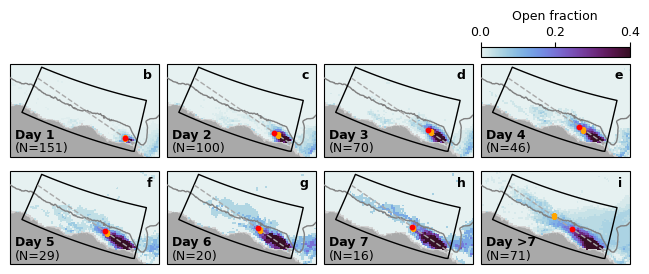

In [86]:
fig, axs = fn.makemap(view='wider_zoom2', contours = [-100], 
                      panels=(2,4), figsize=(8,2.75))
plt.subplots_adjust(hspace=0.025, wspace=0.05)


from pyproj import Geod
g = Geod(ellps='WGS84')
# startlon, startlat = -139, 69.5
startlon, startlat = -139.1, 69.6
# dists = np.array([31,64,79, 101,117,134,144,150])+10

tru_dists = np.array([31.41056723,  64.54320495,
                      79.37149842, 101.65035716, 117.79909441, 134.01560083,
                      144.42282603, 131.747859128])

wind_dists = np.array([31.69151215,  47.77875029,
        66.23453892,  83.33545515, 107.88820641, 124.87097074,
       138.03321063, 207.90784043896])


# for key, n, N in zip(['Dec', 'Jan', 'Feb', 'Mar',],
#                      [0,2,4,6], [1,3,5,7]):

FS = 9
for key, n in zip([f'd{m}' for m in range(1,8)]+[f'd>7'],
                     range(8)):

    axs[n].text(0.95,0.95,f'{chr(97+n+1)}', weight='bold', 
                ha='right', va='top', size=FS, transform=axs[n].transAxes)
    
    ax = axs[n]
    
    ax.add_geometries ([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())
    
    ax.text(0.035,0.175,f'Day {key[1:]}', weight='bold', ha='left', va='bottom', transform=ax.transAxes, size=FS)
    ax.text(0.035,0.025,f'(N={len(event_dates[key])})', ha='left', va='bottom', transform=ax.transAxes, size=FS)
    
    mesh = ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
              vmin=0, vmax=0.4, cmap=cmocean.cm.dense, transform=dsic['proj'])
    
#     ax.contour(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
#                   levels=[0.1,0.2,0.3,0.4,0.5], colors=['k'], linewidths=[0.5,], transform=dsic['proj'])
    
    
    endlon, endlat, backaz = g.fwd(startlon, startlat, -55, 400*1000)
    ax.plot([startlon,endlon], [startlat,endlat], transform=ccrs.PlateCarree(), 
            c='darkgray', lw=1, zorder=100, ls='dashed')
    
    C = 'orange'
    endlon, endlat, backaz = g.fwd(startlon, startlat, -55, wind_dists[n]*1000)
#     ax.plot([startlon,endlon], [startlat,endlat], transform=ccrs.PlateCarree(), 
#             c=C, lw=1, zorder=100, ls='solid')
    ax.scatter(endlon, endlat, transform=ccrs.PlateCarree(), s=10, marker='s', c=C,  zorder=100)
    
    endlon, endlat, backaz = g.fwd(startlon, startlat, -55, tru_dists[n]*1000)
#     ax.plot([startlon,endlon], [startlat,endlat], transform=ccrs.PlateCarree(), 
#             c='r', lw=1, zorder=100, ls='solid')
    ax.scatter(endlon, endlat, transform=ccrs.PlateCarree(), s=10, marker='o', c='r',  zorder=100)

   
#     ax.scatter(startlon, startlat, transform=ccrs.PlateCarree())
    

plotter.add_colorbar(fig, axs[3], [mesh], cb_placement='top', cb_orientation='auto', 
                     cb_width=0.035, cb_length_fraction=[0, 1], cb_pad=0.025, cb_ticks=[0,0.2,0.4], 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='Open fraction', labelpad='auto', 
                     cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
                     cb_labelsize=FS, draw_edges=False, edge_params=['k', 2])


fig.savefig('../figures/results/dailyevent_maps.png', dpi=400, bbox_inches='tight', pad_inches=0)



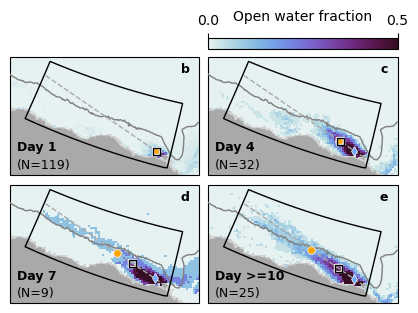

In [154]:
fig, axs = fn.makemap(view='wider_zoom2', contours = [-100], 
                      panels=(2,2), figsize=(5,3.25))
plt.subplots_adjust(hspace=0.05, wspace=0.05)


from pyproj import Geod
g = Geod(ellps='WGS84')
# startlon, startlat = -139, 69.5
startlon, startlat = -139.1, 69.6
# dists = np.array([31,64,79, 101,117,134,144,150])+10

# tru_dists = np.array([31.41056723,  64.54320495,
#                       79.37149842, 101.65035716, 117.79909441, 134.01560083,
#                       144.42282603, 131.747859128])

# wind_dists = np.array([31.69151215,  47.77875029,
#         66.23453892,  83.33545515, 107.88820641, 124.87097074,
#        138.03321063, 207.90784043896])

wind = np.array([29.67029984, 81.62365485, 159.8473894, 174.82151541])
latt = np.array([29.93782605, 33.22366475,  35.32942831, 33.74427032])
obss = np.array([29.38230774, 76.14685572, 107.23015109, 83.90562419])

# for key, n, N in zip(['Dec', 'Jan', 'Feb', 'Mar',],
#                      [0,2,4,6], [1,3,5,7]):

FS = 9
for key, n in zip([f'd{m}' for m in [1,4,7]]+[f'd>=10'],
                     range(6)):

    axs[n].text(0.95,0.95,f'{chr(97+n+1)}', weight='bold', 
                ha='right', va='top', size=FS, transform=axs[n].transAxes)
    
    ax = axs[n]
    
    ax.add_geometries ([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())
    
    ax.text(0.035,0.175,f'Day {key[1:]}', weight='bold', ha='left', va='bottom', transform=ax.transAxes, size=FS)
    ax.text(0.035,0.025,f'(N={len(event_dates[key])})', ha='left', va='bottom', transform=ax.transAxes, size=FS)
    
    mesh = ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
              vmin=0, vmax=0.5, cmap=cmocean.cm.dense, transform=dsic['proj'])
    
#     mesh = ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['sic_mean'], 
#               vmin=0, vmax=100, cmap=cmocean.cm.ice, transform=dsic['proj'])
    
#     ax.contour(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
#                   levels=[0.25, 0.5], colors=['gold'], linewidths=[0.5,], transform=dsic['proj'])
    
    
    endlon, endlat, backaz = g.fwd(startlon, startlat, -55, 400*1000)
    ax.plot([startlon,endlon], [startlat,endlat], transform=ccrs.PlateCarree(), 
            c='darkgray', lw=1, zorder=100, ls='dashed')
    
    endlon, endlat, backaz = g.fwd(startlon, startlat, -55, latt[n]*1000)
    ax.scatter(endlon, endlat, transform=ccrs.PlateCarree(), 
               s=25, marker='d', facecolor=[111/255,171/255,255/255], edgecolor='white',lw=0.5, zorder=100)
    
   
    
    endlon, endlat, backaz = g.fwd(startlon, startlat, -55, wind[n]*1000)
    ax.scatter(endlon, endlat, transform=ccrs.PlateCarree(), 
               s=30, marker='o', facecolor='orange', edgecolor='white', lw=0.5, zorder=100)
    
    
    endlon, endlat, backaz = g.fwd(startlon, startlat, -55, obss[n]*1000)
    ax.scatter(endlon, endlat, transform=ccrs.PlateCarree(), 
               s=25, marker='s', edgecolor='white', facecolor='None',lw=1.75, 
               zorder=100)
    ax.scatter(endlon, endlat, transform=ccrs.PlateCarree(), 
               s=25, marker='s', edgecolor='k', facecolor='None', zorder=100)

#     ax.scatter(startlon, startlat, transform=ccrs.PlateCarree())
    
plotter.add_colorbar(fig, axs[1], [mesh], cb_placement='top', cb_orientation='auto', 
                     cb_width=0.035, cb_length_fraction=[0, 1], cb_pad=0.025, cb_ticks=[0,0.5], 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='Open water fraction', labelpad=-5, 
                     cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
                     cb_labelsize=FS+1, draw_edges=False, edge_params=['k', 2])


# fig.savefig('../figures/results/dailyevent_maps_v1.png', dpi=400, bbox_inches='tight', pad_inches=0)



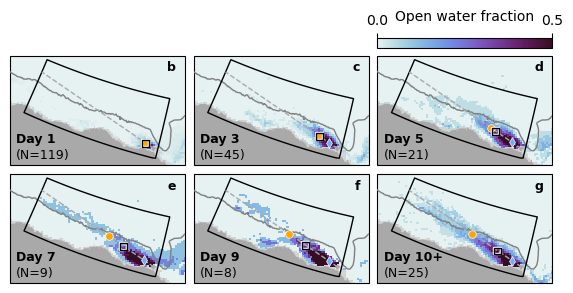

In [ ]:
65/255, 105/255, 225/255

In [51]:
map_sic.keys()

dict_keys(['all', 'b1', 'a1', 'comp', 'd1', 'd3', 'd5', 'd7', 'd9', 'd>=10'])

In [62]:

plt.show()

In [450]:
drift_map.keys()

dict_keys(['all', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd>=8'])

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_99890/996813137.py:46: RuntimeWarning: Mean of empty slice
  sb = np.nanmean(np.sqrt(drift_map[keyb]['u']**2+drift_map[keyb]['v']**2), axis=0)*units('cm/s').to('km/day').magnitude
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_99890/996813137.py:47: RuntimeWarning: Mean of empty slice
  s1 = np.nanmean(np.sqrt(drift_map[key]['u']**2+drift_map[key]['v']**2), axis=0)*units('cm/s').to('km/day').magnitude
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_99890/996813137.py:48: RuntimeWarning: Mean of empty slice
  u1 = np.nanmean(drift_map[key]['u'], axis=0)*units('cm/s').to('m/day').magnitude
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_99890/996813137.py:49: RuntimeWarning: Mean of empty slice
  v1 = np.nanmean(drift_map[key]['v'], axis=0)*units('cm/s').to('m/day').magnitude


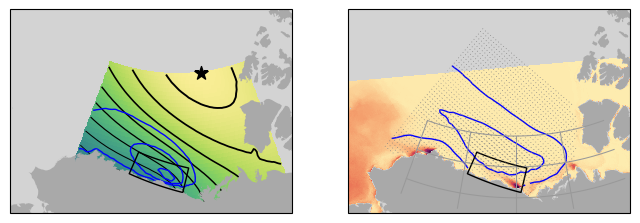

In [854]:
fig, axs = fn.makemap(view='large_view', panels=(1,2), contours = [])

for ax in axs:
    ax.add_geometries ([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())
    
line_kwargs = {'lw':0.75, 'c':[0.6,0.6,0.6]}
for lat in [69,71,73]:
    ax.plot(np.linspace(-160,-120,100), np.full(100,lat), transform=ccrs.PlateCarree(), **line_kwargs)  
for lon in [-160,-150,-140,-130]:
    ax.plot(np.full(100,lon), np.linspace(68,73,100), transform=ccrs.PlateCarree(), **line_kwargs)
    
    
    
key = 'all'
keyb = 'comp'

ax = axs[0]

LEVELS = np.arange(1001,1040,2)
LW = 2*(LEVELS-LEVELS.min())/(LEVELS.max()-LEVELS.min())
ax.contour(era_map[key]['lon'], era_map[key]['lat'],
           (np.nanmean(era_map[key]['msl'], axis=0))/100, 
            levels=LEVELS, colors=['k'],  linewidths = LW,
           transform=ccrs.PlateCarree(), zorder=-99)

ax.pcolormesh(era_map[key]['lon'], era_map[key]['lat'],
            (np.nanmean(era_map[key]['msl'], axis=0))/100, 
              vmin=1000,vmax=1028,
              cmap=cmocean.cm.haline, transform=ccrs.PlateCarree(), zorder=-101)

sw1 = np.nanmean(np.sqrt(era_map[key]['u10']**2+era_map[key]['v10']**2), axis=0)
ax.contour(era_map[key]['lon'], era_map[key]['lat'],sw1,
            levels=[8,9,10], colors=['b'],  linewidths = 1,
           transform=ccrs.PlateCarree(), zorder=0)


max_msl = np.nanmax(np.nanmean(era_map[key]['msl'], axis=0))

ax.scatter(era_map[key]['lon'][np.where(np.nanmean(era_map[key]['msl'], axis=0)==max_msl)], 
           era_map[key]['lat'][np.where(np.nanmean(era_map[key]['msl'], axis=0)==max_msl)],
           transform=ccrs.PlateCarree(), zorder=100, marker='*', c='k', s=100)


ax = axs[1]

sb = np.nanmean(np.sqrt(drift_map[keyb]['u']**2+drift_map[keyb]['v']**2), axis=0)*units('cm/s').to('km/day').magnitude
s1 = np.nanmean(np.sqrt(drift_map[key]['u']**2+drift_map[key]['v']**2), axis=0)*units('cm/s').to('km/day').magnitude
u1 = np.nanmean(drift_map[key]['u'], axis=0)*units('cm/s').to('m/day').magnitude
v1 = np.nanmean(drift_map[key]['v'], axis=0)*units('cm/s').to('m/day').magnitude

ax.quiver(drift_map[key]['xx'], drift_map[key]['yy'], 
          u1, v1, 
          angles='xy', scale_units='xy', transform=drift_map[key]['proj'],
          scale=1, width=0.0035, color='gray', pivot='tail', zorder=100)

ax.contour(drift_map[key]['xx'], drift_map[key]['yy'], s1, 
            levels=[10,15,20], colors=['b'],  linewidths = 1,
           transform=drift_map[key]['proj'], zorder=0)


ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
              vmin=0, vmax=0.5, cmap=cmocean.cm.matter, transform=dsic['proj'], zorder=-1000)

# ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['sic_mean']-map_sic['comp']['sic_mean'], 
#               vmin=-50, vmax=50, cmap=cmocean.cm.balance, transform=dsic['proj'], zorder=-1000)

# newcmap = cmocean.tools.crop_by_percent(cmocean.cm.balance, 50, which='max', N=None)
# ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['sic_mean'], 
#               vmin=10, vmax=100, cmap=newcmap, transform=dsic['proj'], zorder=-1000)


# ax.pcolormesh(drift_map[key]['xx'], drift_map[key]['yy'], s1,
#               vmin=5,vmax=20, cmap=cmocean.cm.speed, transform=drift_map[key]['proj'], zorder=-100)

# sw1 = np.nanmean(np.sqrt(era_map[key]['u10']**2+era_map[key]['v10']**2), axis=0)
# ax.pcolormesh(era_map[key]['lon'], era_map[key]['lat'], sw1, 
#               vmin=0,vmax=10, cmap=cmocean.cm.haline, zorder=-100, transform=ccrs.PlateCarree())


# ax.coastlines(zorder=101)

fig.savefig('../figures/results/comp_map_all.png', dpi=400, bbox_inches='tight', pad_inches=0)


In [574]:
import matplotlib.path as mpath

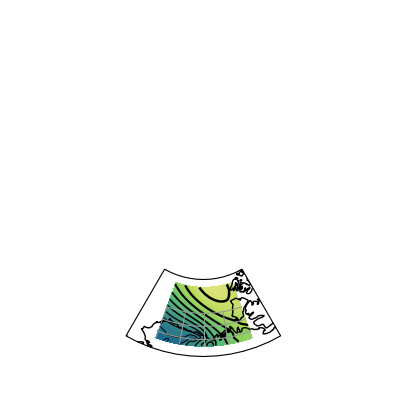

In [828]:
map_proj = ccrs.NorthPolarStereo(central_longitude=-140)
fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(5,5))
line_kwargs = {'lw':0.75, 'c':[0.6,0.6,0.6]}
for lat in [69,71,73]:
    ax.plot(np.linspace(-160,-120,100), np.full(100,lat), transform=ccrs.PlateCarree(), **line_kwargs)  
for lon in [-160,-150,-140,-130]:
    ax.plot(np.full(100,lon), np.linspace(68,73,100), transform=ccrs.PlateCarree(), **line_kwargs)
    
# Limit the map to -60 degrees latitude and below.
ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
# theta = np.linspace(0, 2*np.pi, 72)
theta = np.arange(0, 361, 5) * np.pi/180

IND = 30
# circle 1
center, radius = [0.5, 0.5], 0.4
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
vals = (verts * radius) + center

# circle2
vals2 = np.copy(vals[IND:-IND])
vals2[0] = center
vals2[-1] = center

# circle3
center, radius = [0.5, 0.5], 0.2
vertsn = np.vstack([np.sin(theta), np.cos(theta)]).T
valsn = (vertsn * radius) + center

# stitch together
VALS = np.copy(vals[IND:-IND])
VALS = np.concatenate((VALS, valsn[IND:-IND,:][::-1]), axis=0)


circle = mpath.Path(VALS)
ax.set_boundary(circle, transform=ax.transAxes)
ax.coastlines()

ax.pcolormesh(era_map[key]['lon'], era_map[key]['lat'],
            (np.nanmean(era_map[key]['msl'], axis=0))/100, 
              vmin=1000,vmax=1030,
              cmap=cmocean.cm.haline, transform=ccrs.PlateCarree(), zorder=-101)

ax.contour(era_map[key]['lon'], era_map[key]['lat'],
           (np.nanmean(era_map[key]['msl'], axis=0))/100, 
            levels=LEVELS, colors=['k'],  linewidths = LW,
           transform=ccrs.PlateCarree(), zorder=-99)

# ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
#               vmin=0, vmax=0.5, cmap=cmocean.cm.matter, transform=dsic['proj'], zorder=-1000)

# plt.subplots_adjust(top=0.1, bottom=-0.2, left=-0.3, right=1.3)

fig.savefig('/Users/mackenziejewell/Desktop/testimg.png', dpi=330, bbox_inches='tight', pad_inches=0)

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_99890/3268696089.py:36: RuntimeWarning: Mean of empty slice
  u1 = np.nanmean(drift_map[key]['u'], axis=0)*units('cm/s').to('m/day').magnitude
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_99890/3268696089.py:37: RuntimeWarning: Mean of empty slice
  v1 = np.nanmean(drift_map[key]['v'], axis=0)*units('cm/s').to('m/day').magnitude


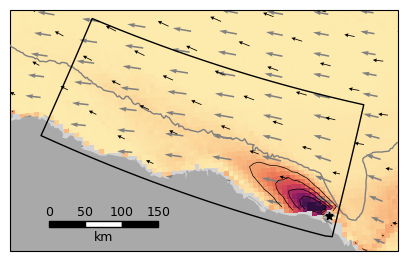

In [708]:
sys.path.append('../')
import functions as fn
fig, ax = fn.makemap(view='wider_zoom2', contours = [-100,], figsize=(5,5))

geomap.scalebar(ax, loc=(0.1, 0.1), steps=[50,100,150],unit='km', 
                label=None, colors=['k', 'w'], edgecolor=None, textsize=9, lw=1, 
                bar_width=0.025, labelpad=0.015, ticklabelpad=0.01, zorder=100, clip_on=True)

from pyproj import Geod
g = Geod(ellps='WGS84')
startlon, startlat = -139.1, 69.6
ax.scatter(startlon, startlat, zorder=100, s= 30, marker='*', c='k', transform=ccrs.PlateCarree())

ax.add_geometries ([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())

# around_HI = {}
# around_HI['lon'] = []
# around_HI['lat'] = []
# for dist in [50]:
#     for az in np.linspace(-90,140,30):
#         endlon, endlat, backaz = g.fwd(startlon, startlat, az, dist*1000)
#         around_HI['lon'].append(endlon)
#         around_HI['lat'].append(endlat)
        
# ax.plot(around_HI['lon'], around_HI['lat'], c='k', 
#         ls='dashed', transform=ccrs.PlateCarree(), zorder=1000)


key = 'all'
ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
              vmin=0, vmax=0.5, cmap=cmocean.cm.matter, transform=dsic['proj'])
ax.contour(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
            levels=[0.1,0.2,0.3,0.4], colors=['k'], linewidths=0.5, transform=dsic['proj'])
    

u1 = np.nanmean(drift_map[key]['u'], axis=0)*units('cm/s').to('m/day').magnitude
v1 = np.nanmean(drift_map[key]['v'], axis=0)*units('cm/s').to('m/day').magnitude
sp = 2
ax.quiver(drift_map[key]['xx'][::sp,::sp], drift_map[key]['yy'][::sp,::sp], 
          u1[::sp,::sp], v1[::sp,::sp], angles='xy', scale_units='xy', transform=drift_map[key]['proj'],
          scale=1, width=0.002, headwidth=5,  color='k', pivot='tail', zorder=100)


    
uw1 = np.nanmean(era_map[key]['u10'], axis=0)
vw1 = np.nanmean(era_map[key]['v10'], axis=0)
sw1 = np.nanmean(np.sqrt(era_map[key]['u10']**2+era_map[key]['v10']**2), axis=0)

sp1 = 1
sp2 = 7
ax.quiver(era_map[key]['lon'][::sp1,::sp2], era_map[key]['lat'][::sp1,::sp2], 
         *geomap.fix_cartopy_vectors((uw1)[::sp1,::sp2], 
                                     (vw1)[::sp1,::sp2], 
                                     era_map[key]['lat'][::sp1,::sp2]), 
          scale = 180, width = 0.004,color='gray',
          transform=ccrs.PlateCarree())

# ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
#               vmin=0, vmax=0.5, cmap=cmocean.cm.matter, transform=dsic['proj'])

In [702]:
era_map.keys()

dict_keys(['all', 'b1', 'a1', 'comp', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd>=8'])

In [289]:
dates = pd.to_datetime(DF.time[(DF['event_day']==5)&(shoulder==False)].values)

SIC = unisic.open_local_file(dates[21], res = '6250', hem ='n', 
                    main_path = '/Volumes/Seagate_Jewell/KenzieStuff/',
                    crop = crop,
                     coordinates = False, area = False,
                     include_units = False, quiet = True,)

In [291]:
dates[21]

Timestamp('2022-03-02 00:00:00')

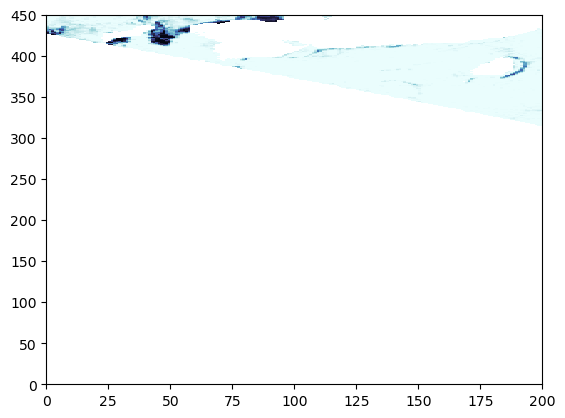

In [290]:
plt.pcolormesh(SIC['sic'], vmin=0, vmax=100, cmap=cmocean.cm.ice)

In [527]:
np.sum(flag_dates == False)

87

/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)


2019-12-12 00:00:00


/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)


2024-01-14 00:00:00


/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)


2022-02-28 00:00:00


/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)


2025-03-11 00:00:00


/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)


2016-04-12 00:00:00


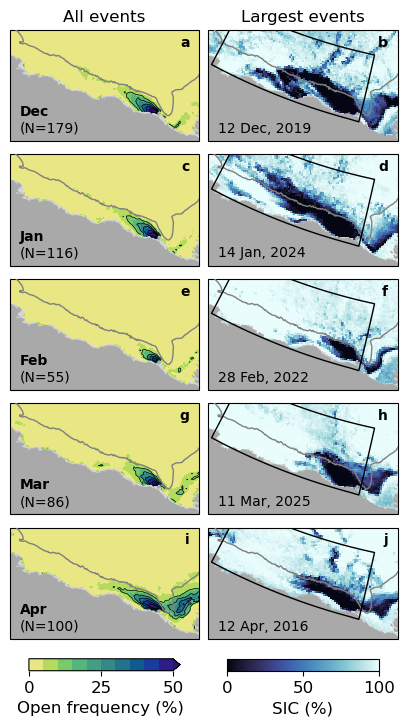

In [569]:
fig, axs = fn.makemap(view='wider_zoom', contours = [-100], 
                      panels=(5,2), figsize=(5,8))
plt.subplots_adjust(hspace=0.05, wspace=0.05)



for key, n, N in zip(['Dec', 'Jan', 'Feb', 'Mar', 'Apr'],
                     [0,2,4,6,8], [1,3,5,7,9]):

    
    axs[n].text(0.95,0.95,f'{chr(97+n)}', weight='bold', 
                ha='right', va='top', transform=axs[n].transAxes)
    axs[N].text(0.95,0.95,f'{chr(97+N)}', weight='bold', 
                ha='right', va='top', transform=axs[N].transAxes)

    
    
    ax = axs[n]
    
    ax.text(0.05,0.2,key, weight='bold', ha='left', va='bottom', transform=ax.transAxes)
    ax.text(0.05,0.05,f'(N={len(event_dates[key])})', ha='left', va='bottom', transform=ax.transAxes)
    
#     ax.add_geometries ([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())
    
    
#     mesh1 = ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], 
#                           100*map_sic[key]['open_freq'], 
#                   vmin=0, vmax=50, cmap=cmocean.cm.haline_r, transform=dsic['proj'])
    
    mesh1 = ax.contourf(map_sic[key]['xx'], map_sic[key]['yy'],  100*map_sic[key]['open_freq'], 
                  levels=np.arange(0,51,5), vmin=0, vmax=50, extend='max',  cmap=cmocean.cm.haline_r, 
                linewidths=0.5,  transform=dsic['proj'])
    

#     ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['sic_mean'], 
#                   vmin=0, vmax=100, cmap=cmocean.cm.ice, transform=dsic['proj'])
    
    ax.contour(map_sic[key]['xx'], map_sic[key]['yy'], 
               ma.masked_where(np.isnan(map_sic[key]['sic_mean']), 100*map_sic[key]['open_freq']), 
                  levels=[10,20,30,40,50], colors=['k'], linewidths=0.5,  transform=dsic['proj'])



#     ax.contour(map_sic[key]['xx'], map_sic[key]['yy'], 
#            ma.masked_where(np.isnan(map_sic[key]['sic_mean']), 100*map_sic[key]['open_freq']), 
#               levels=[10,20,30,40,50], colors=['k'], linewidths=0.5,  transform=dsic['proj'])




    
    
    
    
    # SPECIFIC EVENTS
    #------------------------------
    # flag dates in three years during freezeup/breakup
    current_dates = pd.to_datetime(event_dates[key])
    flag_dates = np.full(len(current_dates), False)
    flag_dates[(current_dates >= datetime(2007,12,1)) & (current_dates <= datetime(2007,12,15))] = True
    flag_dates[(current_dates >= datetime(2016,4,19)) & (current_dates <= datetime(2016,4,30))] = True
    flag_dates[(current_dates >= datetime(2018,4,30)) & (current_dates <= datetime(2018,4,30))] = True
    
    
    spec_ind = np.where(event_sizes[key] == np.max(event_sizes[key][flag_dates==False]))[0][0]
    spec_date = current_dates[spec_ind]
    print(spec_date)
    spec_sic = unisic.open_local_file(spec_date, res=RES, crop=crop, 
                                      coordinates=False, area=False, include_units=False, quiet=True)
    ax = axs[N]
    ax.add_geometries([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())
    mesh2 = ax.pcolormesh(spec_sic['xx'], spec_sic['yy'], spec_sic['sic'], 
                      vmin=0, vmax=100, cmap=cmocean.cm.ice, transform=spec_sic['proj'])

    
    ax.text(0.05,0.05,spec_date.strftime('%d %b, %Y'), 
            ha='left', va='bottom', transform=ax.transAxes)

    
    

plotter.add_colorbar(fig, axs[8], [mesh1], cb_placement='bottom', cb_orientation='auto', 
             cb_width=0.015, cb_length_fraction=[0.1, 0.9], cb_pad=0.025, cb_ticks=[0,25,50], 
             cb_ticklabels='auto', cb_extend='neither', cb_label='Open frequency (%)', labelpad='auto', 
             cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
             cb_labelsize=12, draw_edges=False, edge_params=['k', 2])

plotter.add_colorbar(fig, axs[9], [mesh2], cb_placement='bottom', cb_orientation='auto', 
             cb_width=0.015, cb_length_fraction=[0.1, 0.9], cb_pad=0.025, cb_ticks='auto', 
             cb_ticklabels='auto', cb_extend='neither', cb_label='SIC (%)', labelpad='auto', 
             cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
             cb_labelsize=12, draw_edges=False, edge_params=['k', 2])

axs[0].set_title('All events')
axs[1].set_title('Largest events')

fig.savefig('../figures/results/monthly_maps_cf.png', dpi=400, bbox_inches='tight', pad_inches=0)

In [558]:
n

0

In [531]:
np.sum(np.isnan(map_sic[key]['open_freq']))

168819

In [532]:
np.sum(np.isnan(map_sic[key]['sic_mean']))



168819

In [524]:
help(plotter.add_colorbar)

Help on function add_colorbar in module plot_simply.general:

add_colorbar(fig, ax, colorbar_input, cb_placement='left', cb_orientation='auto', cb_width='auto', cb_length_fraction=[0, 1], cb_pad=0, cb_ticks='auto', cb_ticklabels='auto', cb_extend='neither', cb_label=' ', labelpad='auto', cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, cb_labelsize=12, draw_edges=False, edge_params=['k', 2])
    Function for plotting colorbar along edge of figure axis.

    INPUT:
    - fig: figure to which colorbar will be added
    - ax: figure axis to which colorbar will be added
    - colorbar_input: either specify [matplotlib.collections.QuadMesh], pmatplotlib.cm.ScalarMappable] (from pcolormesh plot output),
                        [cartopy.mpl.contour.GeoContourSet] (from countourf output),
                      or specify [cmap, norm]
                       where cmap is matplotlib cmap (e.g. 'RdBu')
                       where norm is matplotlib.colors normlalization ins

In [520]:
spec_date.strftime('%d %b, %Y')

'12 Apr, 2016'

In [ ]:
uwt = np.fulle
vwt = np.nanmean(era_map[key]['v10'], axis=0)

In [81]:
era_map[key].keys()

dict_keys(['u10', 'v10', 'msl', 'lon', 'lat'])

# Reference vectors

In [1615]:
upslope = {}

upslope['m1'] = {}
upslope['m1']['angle'] = 145 * units('degree')

upslope['m2'] = {}
upslope['m2']['angle'] = -150 * units('degree')

upslope['m3'] = {}
upslope['m3']['angle'] = -115 * units('degree')

upslope['m4'] = {}
upslope['m4']['angle'] = -90 * units('degree')


for m, M in zip([m1, m2, m3, m4], upslope.keys()):
    
    mag = 0.1
    cu = mag*np.cos(upslope[M]['angle'].to('rad'))
    cv = mag*np.sin(upslope[M]['angle'].to('rad'))

    map_proj = ccrs.NorthPolarStereo(central_longitude=-140)
    tail, tip, vec = vectors.project_vectors(map_proj, m.attrs['lon'], m.attrs['lat'], 
                    eastward=cu*units('m/s'), 
                    northward=cv*units('m/s'), final_units='m/day')
    
    upslope[M]['tail'] = tail
    upslope[M]['tip'] = tip
    upslope[M]['vec'] = vec


# find 2016-2018 dates

In [59]:
all_spec_dates = np.array([], dtype=np.datetime64)

all_spec_dates = pd.to_datetime(DF.time[ (DF.extent > 0) & ((DF.year == 2017) + (DF.year == 2018))].values)
all_other_dates = pd.to_datetime(DF.time[ (DF.extent == 0) & ((DF.year == 2017) + (DF.year == 2018))].values)
# for ss in all_seqs.keys():
#     if (all_seqs[ss][0] >= datetime(2016,12,1)) & (all_seqs[ss][-1] <= datetime(2018,4,30)):
#         all_spec_dates = np.append(all_spec_dates, all_seqs[ss])
# print(all_spec_dates[0], all_spec_dates[-1])

# all_other_dates = np.array([], dtype=np.datetime64)
# for date in pd.date_range(all_spec_dates[0], all_spec_dates[-1]):
#     if date not in all_spec_dates:
#         if date.month not in [5,6,7,8,9,10,11]:
#             all_other_dates = np.append(all_other_dates,date)

In [60]:
spec_y1 = all_spec_dates[all_spec_dates < datetime(2017,11,1)]
spec_y2 = all_spec_dates[all_spec_dates > datetime(2017,11,1)]

other_y1 = all_other_dates[all_other_dates < datetime(2017,11,1)]
other_y2 = all_other_dates[all_other_dates > datetime(2017,11,1)]



## Calc mean flows

In [65]:
mvec = {}
mvec['m1'] = {}
mvec['m1']['depth_range'] = (-50,0)

mvec['m2'] = {}
mvec['m2']['depth_range'] = (-150,-50)

mvec['m3'] = {}
mvec['m3']['depth_range'] = (-150,-50)

mvec['m4'] = {}
mvec['m4']['depth_range'] = (-150,-50)


groups = ['open', 'comp']

for M in mvec.keys():
    
    for group in groups:
        
        mvec[M][group] = {}

        mvec[M][group]['tip_x'] = np.array([])
        mvec[M][group]['tip_y'] = np.array([])

        mvec[M][group]['vec_x'] = np.array([])
        mvec[M][group]['vec_y'] = np.array([])
        
        mvec[M][group]['itip_x'] = np.array([])
        mvec[M][group]['itip_y'] = np.array([])

        mvec[M][group]['ivec_x'] = np.array([])
        mvec[M][group]['ivec_y'] = np.array([])



In [66]:

for spec_y_dates, other_y_dates, open_years in zip([spec_y1, spec_y2], 
                                                   [other_y1, other_y2],
                                                   ['2016_2017', '2017_2018']):
    
    # open_years = '2017_2018'
    m1 = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_ocean_currents_{open_years}.nc')
    m2 = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M2/M2_hourly_ocean_currents_{open_years}.nc')
    m3 = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M3/M3_hourly_ocean_currents_{open_years}.nc')
    m4 = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M4/M4_hourly_ocean_currents_{open_years}.nc')

    m1i = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_seaice_velocity_{open_years}.nc')
    m2i = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M2/M2_hourly_seaice_velocity_{open_years}.nc')
    m3i = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M3/M3_hourly_seaice_velocity_{open_years}.nc')
    m4i = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M4/M4_hourly_seaice_velocity_{open_years}.nc')

    m1t = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_tempsalinity_{open_years}.nc')
    m2t = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M2/M2_hourly_tempsalinity_{open_years}.nc')
    m3t = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M3/M3_hourly_tempsalinity_{open_years}.nc')
    m4t = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M4/M4_hourly_tempsalinity_{open_years}.nc')

    print(open_years)
    
    for m, mi, M in zip([m1, m2, m3, m4], [m1i, m2i, m3i, m4i], mvec.keys()):
        
        print(M)
        
        for group, dates in zip(['open', 'comp'], [spec_y_dates, other_y_dates]):
            
            cdata = mvec[M][group]

            tails, tips, vecs = grab_vector_range(m, dates, depth_range = mvec[M]['depth_range'], daily_means=True)

            # grab tips
            cdata['tip_x'] = np.append(cdata['tip_x'], np.array([tip[0] for tip in tips]))
            cdata['tip_y'] = np.append(cdata['tip_y'], np.array([tip[1] for tip in tips]))

            # grab tails
            cdata['tail_x'] = np.nanmean(np.array([tail[0] for tail in tails]))
            cdata['tail_y'] = np.nanmean(np.array([tail[1] for tail in tails]))


            # grab vectors
            cdata['vec_x'] = np.append(cdata['vec_x'], np.array([vec[0].magnitude for vec in vecs]))
            cdata['vec_y'] = np.append(cdata['vec_y'], np.array([vec[1].magnitude for vec in vecs]))

            
            
            # ICE VELOCITIES
            tails, tips, vecs = grab_icevector_range(mi, dates)

            # grab tips
            cdata['itip_x'] = np.append(cdata['itip_x'], np.array([tip[0] for tip in tips]))
            cdata['itip_y'] = np.append(cdata['itip_y'], np.array([tip[1] for tip in tips]))

            # grab tails
            cdata['itail_x'] = np.nanmean(np.array([tail[0] for tail in tails]))
            cdata['itail_y'] = np.nanmean(np.array([tail[1] for tail in tails]))


            # grab vectors
            cdata['ivec_x'] = np.append(cdata['ivec_x'], np.array([vec[0].magnitude for vec in vecs]))
            cdata['ivec_y'] = np.append(cdata['ivec_y'], np.array([vec[1].magnitude for vec in vecs]))

    
    
for M in mvec.keys():
    
    for group in ['open', 'comp']:

        cdata = mvec[M][group]
        
        x = cdata['vec_x']
        y = cdata['vec_y']

        cdata['mean_x'] = np.nanmean(cdata['vec_x'])
        cdata['mean_y'] = np.nanmean(cdata['vec_y'])

        xp = x[np.isfinite(x)&np.isfinite(y)]
        yp = y[np.isfinite(x)&np.isfinite(y)]

        # find variance ellipses
        varell = tanalyze.variance_ellipses(xp,yp)
        xm = vectors.comp_along_theta(xp, yp, varell['theta_m'] * units('rad'))
        ym = vectors.comp_along_theta(xp, yp, (varell['theta_m']+np.pi/2) * units('rad'))


        cdata['varell_x'] = varell['xe']
        cdata['varell_y'] = varell['ye']
        
        
        # ice velocities
        #----------------
        x = cdata['ivec_x']
        y = cdata['ivec_y']

        cdata['imean_x'] = np.nanmean(cdata['ivec_x'])
        cdata['imean_y'] = np.nanmean(cdata['ivec_y'])

        xp = x[np.isfinite(x)&np.isfinite(y)]
        yp = y[np.isfinite(x)&np.isfinite(y)]

        # find variance ellipses
        varell = tanalyze.variance_ellipses(xp,yp)
        xm = vectors.comp_along_theta(xp, yp, varell['theta_m'] * units('rad'))
        ym = vectors.comp_along_theta(xp, yp, (varell['theta_m']+np.pi/2) * units('rad'))


        cdata['ivarell_x'] = varell['xe']
        cdata['ivarell_y'] = varell['ye']
    

2016_2017
m1
m2
m3
m4
2017_2018
m1
m2
m3
m4


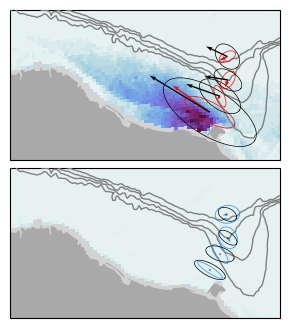

In [78]:
fig, axs = fn.makemap(view='narrowzoom', contours = [-400,-300,-200,-100], figsize=(6,4), panels=(2,1))



# for ax in axs:
#     line_kwargs = {'lw':0.75, 'c':[0.6,0.6,0.6]}
#     for lat in [69,71,73]:
#         ax.plot(np.linspace(-160,-120,100), np.full(100,lat), transform=ccrs.PlateCarree(), **line_kwargs)  
#     for lon in [-160,-150,-140,-130]:
#         ax.plot(np.full(100,lon), np.linspace(68,73,100), transform=ccrs.PlateCarree(), **line_kwargs)


#     for m in ['M1', 'M2', 'M3', 'M4']: 

#         ax.scatter(M[m]['lon'], M[m]['lat'], transform=ccrs.PlateCarree(), c='k')

    

key = 'all'
axs[0].pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
              vmin=0, vmax=0.5, cmap=cmocean.cm.dense, transform=dsic['proj'])

key = 'comp'
axs[1].pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
              vmin=0, vmax=0.5, cmap=cmocean.cm.dense, transform=dsic['proj'])


aw = 0.004

for M in mvec.keys():

    for group, color, ax in zip(['open', 'comp'], ['r', 'dodgerblue'], [axs[0], axs[1]]):

        cdata = mvec[M][group]

        ax.quiver(cdata['tail_x'], cdata['tail_y'], 
                  cdata['mean_x'], cdata['mean_y'], 
                  angles='xy', scale_units='xy', scale=1, color=color, width=1.2*aw, zorder=100)

        ax.plot(cdata['varell_x']+cdata['tail_x'], 
                cdata['varell_y']+cdata['tail_y'], c=color, zorder=100, lw=0.5, alpha=1)

        
        ax.quiver(cdata['itail_x'], cdata['itail_y'], 
                  cdata['imean_x'], cdata['imean_y'], 
                  angles='xy', scale_units='xy', scale=1, color='k', width=1.2*aw, zorder=100)

        ax.plot(cdata['ivarell_x']+cdata['itail_x'], 
                cdata['ivarell_y']+cdata['itail_y'], c='k', zorder=100, lw=0.5, alpha=1)

plt.subplots_adjust(hspace=0.05)

# fig.savefig('../figures/results/canyon_flow_topdown.png', dpi=400, bbox_inches='tight', pad_inches=0)


In [ ]:

# sys.path.append('../../Libraries_functions/')
# from LIB_MODIS_IST_N1kmNIGHT import grab_MODIS_IST

# date1 = datetime(2017,12,16)
# # date2 = datetime(2024,1,8)

# date3 = datetime(2019,12,13)

# # date2 = datetime(2024,1,8)

# # date2 = datetime(2016,4,10)

# date2 = datetime(2024,1,14)
# file_path = f'/Volumes/Seagate_Jewell/KenzieStuff/MODIS_IST_1km_night/{date1.strftime("%Y.%m")}/'
# # IST1 = grab_MODIS_IST(date1, file_path = file_path)
# file_path = f'/Volumes/Seagate_Jewell/KenzieStuff/MODIS_IST_1km_night/{date2.strftime("%Y.%m")}/'
# # IST2 = grab_MODIS_IST(date2, file_path = file_path)

# file_path = f'/Volumes/Seagate_Jewell/KenzieStuff/MODIS_IST_1km_night/{date3.strftime("%Y.%m")}/'
# # IST3 = grab_MODIS_IST(date3, file_path = file_path)

# RES = '3125'
# crop=[1500, 2050, 480, 700]
# sic_key = 'sic'

# # sicsic = unisic.open_local_file(datetime(2019,1,16), res='1000ma2', hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
# #                             crop=[2100, 3400, 340, 800], coordinates=False, area=False, include_units=False, quiet=True)

# sic1 = unisic.open_local_file(date1, res=RES, hem='n', 
#                              main_path='/Volumes/Seagate_Jewell/KenzieStuff/',
#                              crop=crop, coordinates=False, area=False, include_units=False, quiet=True)

# sic2 = unisic.open_local_file(date2, res=RES, hem='n', 
#                              main_path='/Volumes/Seagate_Jewell/KenzieStuff/',
#                              crop=crop, coordinates=False, area=False, include_units=False, quiet=True)



# sic3 = unisic.open_local_file(date3, res=RES, hem='n', 
#                              main_path='/Volumes/Seagate_Jewell/KenzieStuff/',
#                              crop=crop, coordinates=False, area=False, include_units=False, quiet=True)

# fig, axs = fn.makemap(view='wider_zoom3', contours = [-100], 
#                       panels=(1,3), figsize=(9,3))


# # fig, ax = fn.makemap(view='wider_zoom2', contours = [], 
# #                       panels=(1,1), figsize=(4,4))

# for ax in axs:
#     ax.add_geometries ([reg_poly], lw=2, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())


#     line_kwargs = {'lw':0.75, 'c':[0.6,0.6,0.6]}
#     for lat in [70]:
#         ax.plot(np.linspace(-160,-120,100), np.full(100,lat), transform=ccrs.PlateCarree(), **line_kwargs)  
#     for lon in [-140,]:
#         ax.plot(np.full(100,lon), np.linspace(68,73,100), transform=ccrs.PlateCarree(), **line_kwargs)

        
# cmap = cmocean.cm.balance
        
# ax = axs[0]
# # ax.pcolormesh(IST1['xx'], IST1['yy'], IST1['ist']-273.15, 
# #               vmin=-30, vmax=0, cmap=cmap, transform=IST1['proj'])
# # ax.pcolormesh(sic1['xx'], sic1['yy'], sic1['sic'], vmin=0, vmax=100, cmap=cmocean.cm.ice, transform=sic1['proj'])
# ax.contour(sic1['xx'], sic1['yy'], sic1['sic'], levels=[10], colors=['k'],linewidths=[0.5], transform=sic1['proj'])


# ax = axs[2]
# # ax.pcolormesh(sic2['xx'], sic2['yy'], sic2['sic'], vmin=0, vmax=100, cmap=cmocean.cm.ice, transform=sic1['proj'])
# # ax.contour(sic2['xx'], sic2['yy'], sic2['sic'], levels=[10], colors=['gold'],linewidths=[0.5], transform=sic1['proj'])
# # ax.pcolormesh(IST2['xx'], IST2['yy'], IST2['ist']-273.15, 
# #               vmin=-30, vmax=0, cmap=cmap, transform=IST2['proj'])
# ax.contour(sic2['xx'], sic2['yy'], sic2['sic'], levels=[10], colors=['k'],linewidths=[0.5], transform=sic1['proj'])

# ax = axs[1]
# # ax.pcolormesh(sic2['xx'], sic2['yy'], sic2['sic'], vmin=0, vmax=100, cmap=cmocean.cm.ice, transform=sic1['proj'])
# # ax.contour(sic2['xx'], sic2['yy'], sic2['sic'], levels=[10], colors=['gold'],linewidths=[0.5], transform=sic1['proj'])
# # ax.pcolormesh(IST3['xx'], IST3['yy'], IST3['ist']-273.15, 
# #               vmin=-30, vmax=0, cmap=cmap, transform=IST3['proj'])
# ax.contour(sic3['xx'], sic3['yy'], sic3['sic'], levels=[10], colors=['k'],linewidths=[0.5], transform=sic1['proj'])

# plt.subplots_adjust(wspace=0.025)

# # fig.savefig('../figures/results/thermal_maps.png', dpi=400, bbox_inches='tight', pad_inches=0)